# Beam deflection by Euler-Bernoulli beam theory

## 1. Problem formulation

### 1. Problem format

<div>
<img src="./assets/beam.png" width="500" />
</div>

### 2. Self distribution weight $w(x)$

$$
w = \rho A g
$$

### 3. Deflection equation

$$
y(x) = \frac{wx^2}{24EI}(6L^2 - 4Lx + x^2)
$$

### 4. Boundary conditions

$$
\text{at } x = 0 \text{ : } y(0) = 0, y'(0)
$$
$$
\text{at } x = L \text{ : } y''(L) = 0, y'''(L) = 0
$$

> Note: **we don't have the initial condition**, because the it is not time-based problem.

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

from model import PolymorphicModel

In [3]:
loss_function = nn.MSELoss()

In [4]:
def create_collocation(L: int, data_size: int):
    """
    Create collocation data points for ODE loss calculation
    """
    eps: float = 1e-6
    X = torch.linspace(
        eps,
        L,
        data_size + 1,
        dtype=torch.float32,
    ).reshape(-1, 1)
    X.requires_grad = True
    return X


def create_boundary_left(data_size: int):
    """
    Create left boundary data points for Left Boundary loss calculation
    """
    X = torch.tensor([[0.0] * data_size], dtype=torch.float32).reshape(-1, 1)
    X.requires_grad = True
    return X


def create_boundary_right(
    L: int,
    data_size: int,
):
    """
    Create right boundary data points for Right Boundary loss calculation
    """
    X = torch.tensor([[L] * data_size], dtype=torch.float32).reshape(-1, 1)
    X.requires_grad = True
    return X


def generate_gaussian_noise(
    size, mean=0.0, std=1.0, fix_seed: bool = True, device="cpu"
):
    """
    Generates a Gaussian noise vector.

    Args:
        size (int or tuple): The shape of the noise vector (e.g., number of elements).
        mean (float): The mean of the Gaussian distribution.
        std (float): The standard deviation of the Gaussian distribution.
        device (str): The device to generate the noise on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: A tensor of Gaussian noise.
    """

    if fix_seed:
        torch.random.manual_seed(42)

    sign = -1 if random.random() > 0.5 else 1
    noise = torch.randn(size, device=device) * 0.0001
    noise = mean + sign * std * noise
    return noise


def create_sensor_data(L: int, sensor_step: int = 4):
    """
    Create sensor data for the given true solution.

    Noise included
    """

    def true_solution(x):
        return -(x**4) / 24 + x**3 / 6 - x**2 / 4

    X = torch.linspace(0, L, sensor_step, dtype=torch.float32).reshape(-1, 1)

    noise_term = generate_gaussian_noise(sensor_step, std=0.1).reshape(-1, 1)

    Y = true_solution(X) + noise_term

    return X, -Y

In [4]:
model = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 10, 1],
)

In [5]:
def dy(X, Y):
    return torch.autograd.grad(
        Y,
        X,
        grad_outputs=torch.ones_like(Y),
        create_graph=True,
    )[0]


def ddy(X, Y):
    dy_val = dy(X, Y)
    return torch.autograd.grad(
        dy_val,
        X,
        grad_outputs=torch.ones_like(dy_val),
        create_graph=True,
    )[0]


def dddy(X, Y):
    ddy_val = ddy(X, Y)
    return torch.autograd.grad(
        ddy_val,
        X,
        grad_outputs=torch.ones_like(ddy_val),
        create_graph=True,
    )[0]


def ddddy(X, Y):
    dddy_val = dddy(X, Y)
    return torch.autograd.grad(
        dddy_val,
        X,
        grad_outputs=torch.ones_like(dddy_val),
        create_graph=True,
    )[0]


def loss_ode(X, Y_hat):
    ddddy_hat = ddddy(X, Y_hat)
    ode_loss = ddddy_hat - 1
    target_loss = torch.zeros_like(ode_loss)
    return loss_function(ode_loss, target_loss)


def loss_bc_left(X, Y_hat):
    dY_hat = dy(X, Y_hat)
    target_loss_Y_hat = torch.zeros_like(Y_hat)
    target_loss_dY_hat = torch.zeros_like(dY_hat)
    bc_left_loss = loss_function(Y_hat, target_loss_Y_hat)
    bc_left_dy_loss = loss_function(dY_hat, target_loss_dY_hat)
    return bc_left_loss + bc_left_dy_loss


def loss_bc_right(X, Y_hat):
    ddY_hat = ddy(X, Y_hat)
    dddY_hat = dddy(X, Y_hat)
    target_loss_ddY = torch.zeros_like(ddY_hat)
    target_loss_dddY = torch.zeros_like(dddY_hat)
    bc_right_loss = loss_function(ddY_hat, target_loss_ddY)
    bc_right_dy_loss = loss_function(dddY_hat, target_loss_dddY)
    return bc_right_loss + bc_right_dy_loss


def loss_sensor_data(model, X_sensor, Y_sensor):
    Y_hat_sensor = model(X_sensor)
    return loss_function(Y_hat_sensor, Y_sensor)

In [6]:
from typing import Literal


def train(
    model, epoch: int, opt
) -> dict[Literal["tot", "ode", "bc_left", "bc_right", "sensor"], list[float]]:
    # Coarse optimization with Adam
    coarse_optim = torch.optim.Adam(
        model.parameters(),
        lr=opt["lr"],
    )

    # Fine optimization with LBFGS
    fine_optim = torch.optim.LBFGS(
        model.parameters(),
        lr=opt["lr"],
        line_search_fn="strong_wolfe",
        history_size=10,
        max_eval=25,
        max_iter=4,
        tolerance_change=1.0 * np.finfo(float).eps,
    )

    model.train()

    loss_history = {"tot": [], "ode": [], "bc_left": [], "bc_right": [], "sensor": []}

    for epoch_count in range(epoch):
        # Zero gradients for Adam
        coarse_optim.zero_grad()

        # Generate data
        X_collocation = create_collocation(opt["L"], opt["data_size"])
        X_bc_left = create_boundary_left(opt["data_size"])
        X_bc_right = create_boundary_right(opt["L"], opt["data_size"])

        if opt["sensor_step"] is not None:
            X_sensor, Y_sensor = create_sensor_data(
                opt["L"],
                opt["sensor_step"],
            )

        # Forward pass
        Y_collocation = model(X_collocation)
        Y_bc_left = model(X_bc_left)
        Y_bc_right = model(X_bc_right)

        # Compute individual losses
        is_data_driven = opt["data_size"] == 0

        loss_ode_val = loss_ode(X_collocation, Y_collocation)
        loss_bc_left_val = loss_bc_left(X_bc_left, Y_bc_left)
        loss_bc_right_val = loss_bc_right(X_bc_right, Y_bc_right)
        loss_sensor_data_val = (
            loss_sensor_data(model, X_sensor, Y_sensor)
            if opt["sensor_step"] is not None
            else torch.tensor(0.0)
        )

        # Total loss (ensure it is a scalar, not a tuple)
        loss = (
            loss_sensor_data_val
            if is_data_driven
            else (
                loss_ode_val
                + loss_bc_left_val
                + loss_bc_right_val
                + loss_sensor_data_val
            )
        )

        loss_history["tot"].append(loss.item())
        loss_history["ode"].append(loss_ode_val.item())
        loss_history["bc_left"].append(loss_bc_left_val.item())
        loss_history["bc_right"].append(loss_bc_right_val.item())
        loss_history["sensor"].append(loss_sensor_data_val.item())

        # Back-propagate and update using Adam
        loss.backward()
        coarse_optim.step()

        if epoch_count % 100 == 0:
            # Print the progress
            print(
                f"Epoch: {epoch_count}, Loss: {loss.item()}, Loss sensor: {loss_sensor_data_val.item()}, Loss ODE: {loss_ode_val.item()}, Loss BC Left: {loss_bc_left_val.item()}, Loss BC Right: {loss_bc_right_val.item()}"
            )

            # Fine-tuning with LBFGS
            def closure():
                fine_optim.zero_grad()
                # Forward pass
                Y_collocation = model(X_collocation)
                Y_bc_left = model(X_bc_left)
                Y_bc_right = model(X_bc_right)

                if opt["sensor_step"] is not None:
                    X_sensor, Y_sensor = create_sensor_data(
                        opt["L"],
                        opt["sensor_step"],
                    )

                # Recompute the loss for LBFGS
                loss_ode_val = loss_ode(X_collocation, Y_collocation)
                loss_bc_left_val = loss_bc_left(X_bc_left, Y_bc_left)
                loss_bc_right_val = loss_bc_right(X_bc_right, Y_bc_right)
                loss_sensor_data_val = (
                    loss_sensor_data(model, X_sensor, Y_sensor)
                    if opt["sensor_step"] is not None
                    else torch.tensor(0.0)
                )

                # Total loss
                loss = (
                    loss_sensor_data_val
                    if is_data_driven
                    else (
                        loss_ode_val
                        + loss_bc_left_val
                        + loss_bc_right_val
                        + loss_sensor_data_val
                    )
                )

                loss_history["tot"].append(loss.item())
                loss_history["ode"].append(loss_ode_val.item())
                loss_history["bc_left"].append(loss_bc_left_val.item())
                loss_history["bc_right"].append(loss_bc_right_val.item())
                loss_history["sensor"].append(loss_sensor_data_val.item())

                loss.backward()
                return loss

            # Perform LBFGS optimization step
            fine_optim.step(closure)

    return loss_history

In [7]:
from typing import Literal


def plot_result(model, opt, scenario: str):
    with torch.no_grad():
        X = torch.linspace(0, opt["L"], 100).reshape(-1, 1)
        Y = model(X)

        def true_solution(x):
            return -(x**4) / 24 + x**3 / 6 - x**2 / 4

        Y_true = true_solution(X)

        plt.title(scenario)
        plt.grid()
        plt.plot(
            X,
            -Y,
            label="NN",
            color="green",
            linestyle="-",
            linewidth=0.5,
            marker="o",
            markersize=1,
        )
        plt.plot(
            X,
            Y_true,
            label="Ground-true",
            color="blue",
            linewidth=3,
            alpha=0.25,
            linestyle="-",
        )
        plt.legend()
        plt.show()


def log(*args, **kwargs):
    print("-" * 75)
    print(*args, **kwargs)


def plot_history(loss_history, epoch: int, title: str):
    plt.figure(figsize=(10, 10))
    epoch_linspace = np.linspace(0, epoch, len(loss_history["tot"]), endpoint=True)
    plt.plot(
        epoch_linspace,
        loss_history["tot"],
        label="Total Loss",
        color="red",
        linewidth=2,
    )
    plt.plot(
        epoch_linspace,
        loss_history["ode"],
        label="ODE Loss",
        color="blue",
        linewidth=1,
        linestyle="--",
    )
    plt.plot(
        epoch_linspace,
        loss_history["bc_left"],
        label="BC Left Loss",
        color="green",
        linewidth=1,
        linestyle="--",
    )
    plt.plot(
        epoch_linspace,
        loss_history["bc_right"],
        label="BC Right Loss",
        color="purple",
        linewidth=1,
        linestyle="--",
    )
    plt.plot(
        epoch_linspace,
        loss_history["sensor"],
        label="Sensor Loss",
        color="orange",
        linewidth=1,
        linestyle="--",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss History : {title}")
    plt.grid()
    plt.legend()
    plt.show()


def create_scenario(
    scenario_name: str,
    opt: dict[dict[Literal["L", "data_size", "lr", "epoch", "sensor_step"], any]],
    model: PolymorphicModel,
):
    log("Scenario", scenario_name)
    log("Options", opt)

    log(f"Model {scenario_name}", model.model_report)

    log("Training")
    loss_history = train(
        model=model,
        epoch=opt["epoch"],
        opt=opt,
    )
    plot_history(loss_history, opt["epoch"], scenario_name)
    plot_result(model, opt, scenario_name)

---------------------------------------------------------------------------
Scenario no_sensor_2
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 2, 'lr': 0.001, 'epoch': 50, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_2 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.800303041934967, Loss sensor: 0.0, Loss ODE: 0.703685462474823, Loss BC Left: 0.0864904522895813, Loss BC Right: 0.010127155110239983


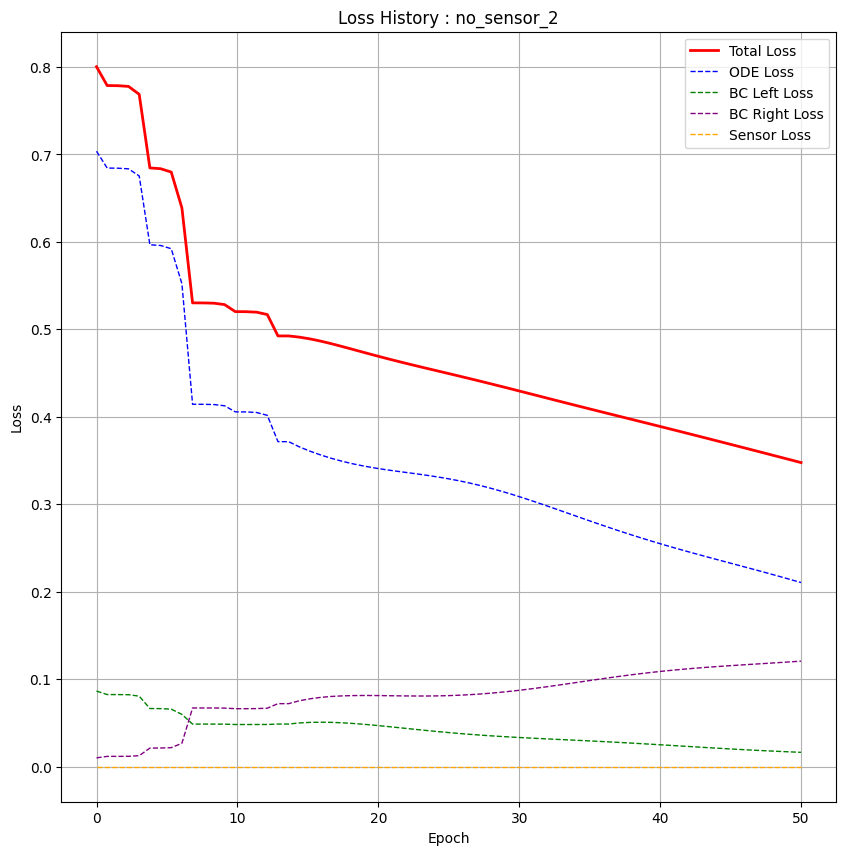

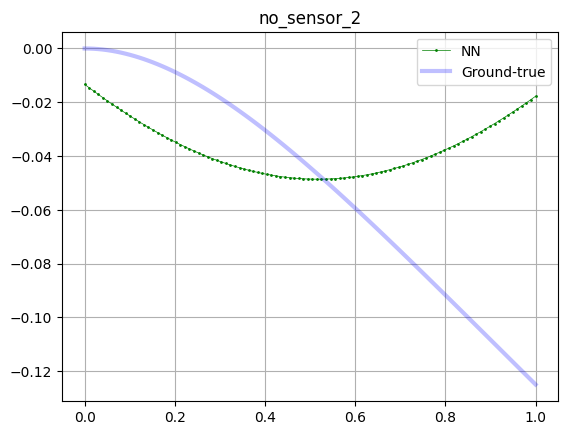

---------------------------------------------------------------------------
Scenario no_sensor_4
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 4, 'lr': 0.001, 'epoch': 50, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_4 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.2976379692554474, Loss sensor: 0.0, Loss ODE: 0.1601228564977646, Loss BC Left: 0.015980055555701256, Loss BC Right: 0.12153507024049759


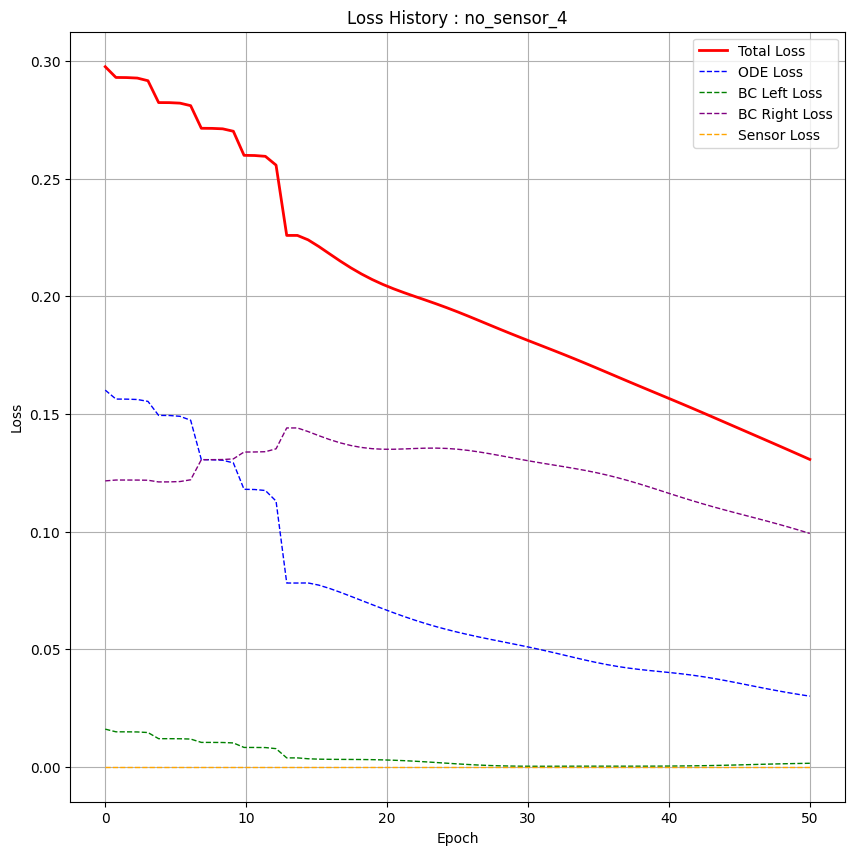

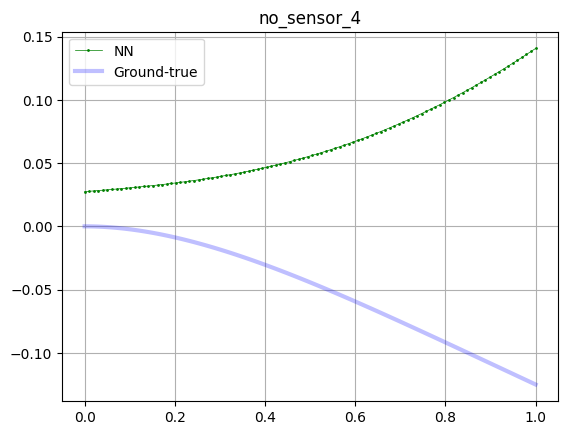

---------------------------------------------------------------------------
Scenario no_sensor_6
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 6, 'lr': 0.001, 'epoch': 50, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_6 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.12682685256004333, Loss sensor: 0.0, Loss ODE: 0.027518153190612793, Loss BC Left: 0.0015341087710112333, Loss BC Right: 0.09777459502220154


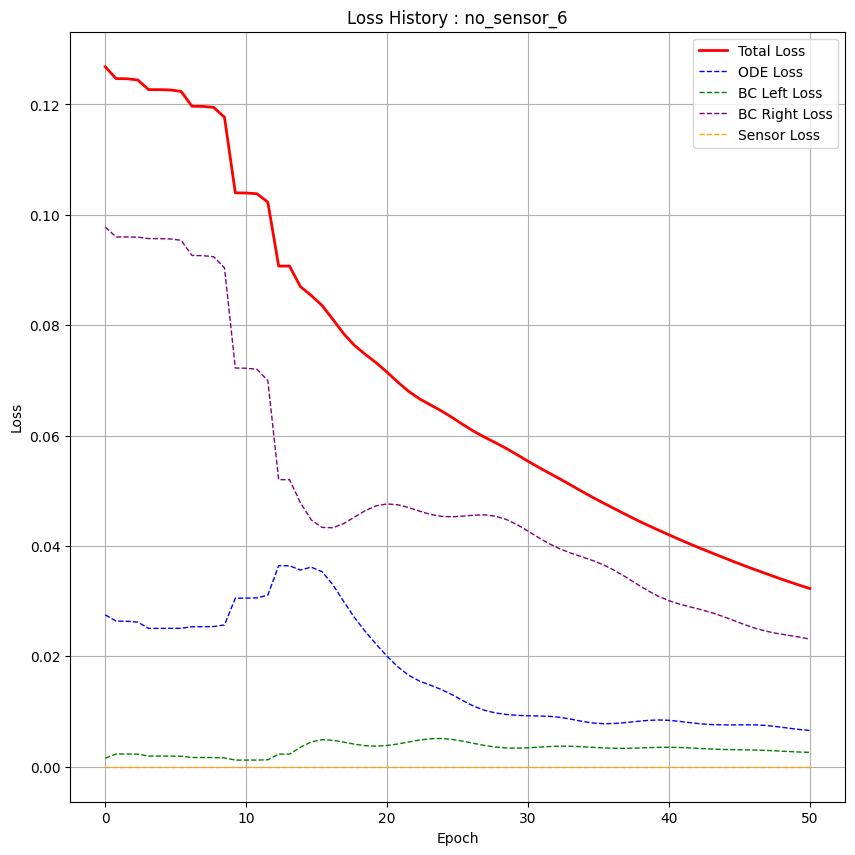

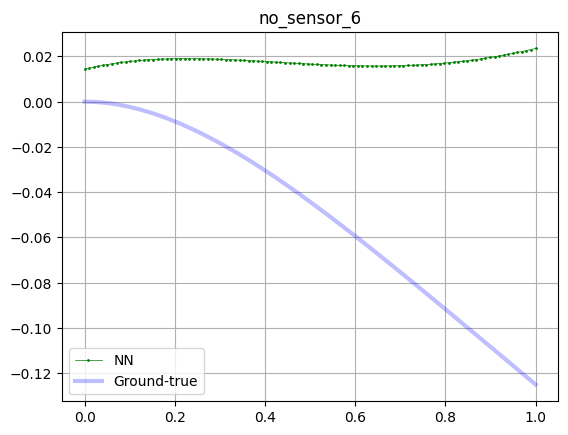

---------------------------------------------------------------------------
Scenario no_sensor_8
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 8, 'lr': 0.001, 'epoch': 50, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_8 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.031059175729751587, Loss sensor: 0.0, Loss ODE: 0.005833236500620842, Loss BC Left: 0.0025719774421304464, Loss BC Right: 0.022653961554169655


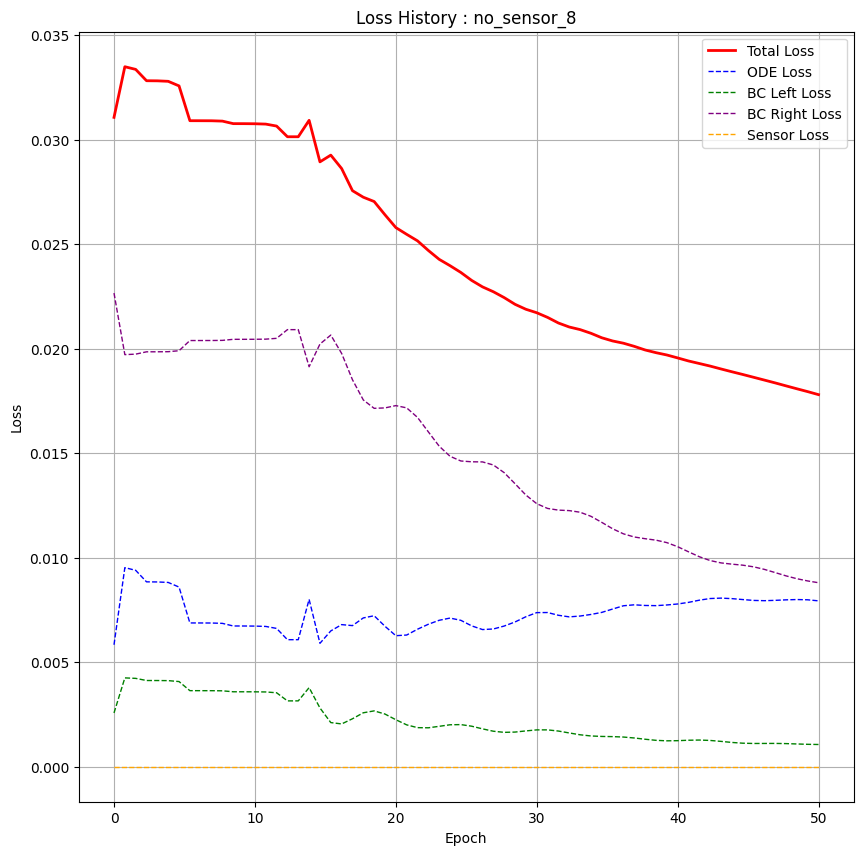

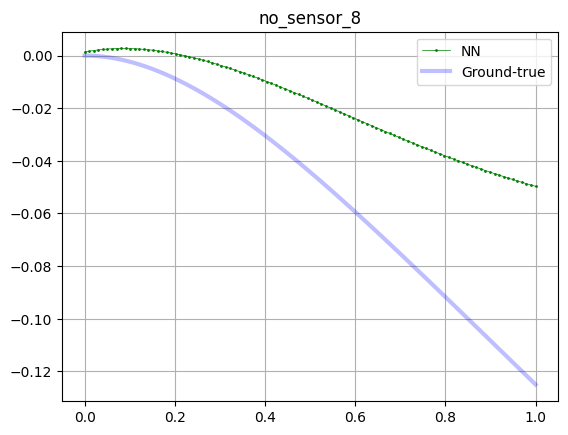

---------------------------------------------------------------------------
Scenario no_sensor_10
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 10, 'lr': 0.001, 'epoch': 50, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_10 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.016984693706035614, Loss sensor: 0.0, Loss ODE: 0.007202556822448969, Loss BC Left: 0.0010626546572893858, Loss BC Right: 0.008719481527805328


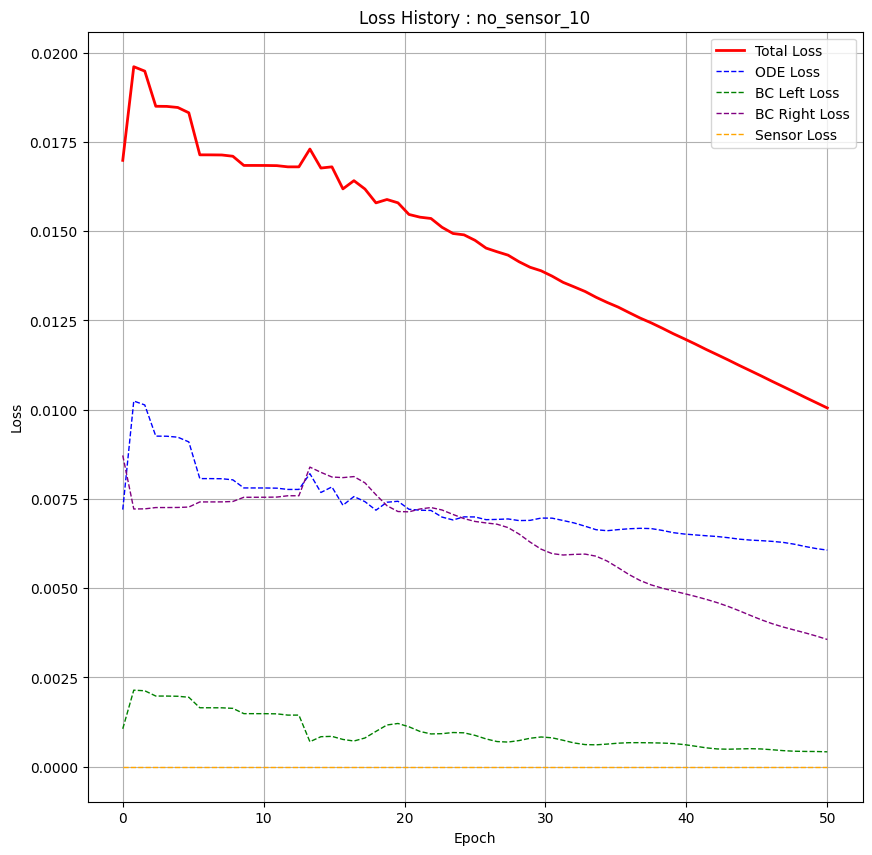

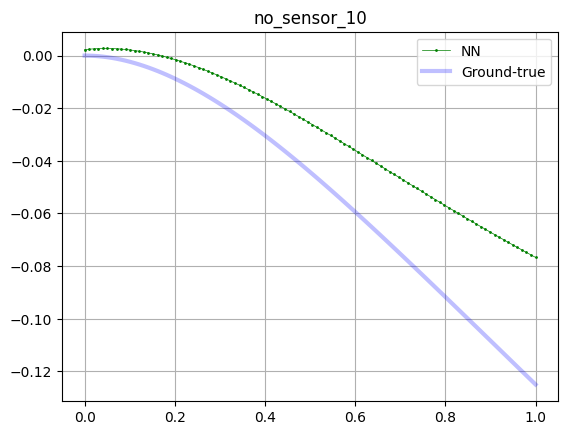

In [26]:
model_low = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 1],
)

data_sizes = [i * 2 for i in range(1, 6)]


for size in data_sizes:
    create_scenario(
        scenario_name=f"no_sensor_{size}",
        opt={"L": 1, "data_size": size, "lr": 1e-3, "epoch": 50, "sensor_step": None},
        model=model_low,
    )

---------------------------------------------------------------------------
Scenario no_sensor_25_collocations
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.001, 'epoch': 2000, 'sensor_step': None}
---------------------------------------------------------------------------
Model no_sensor_25_collocations Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.8568130731582642, Loss sensor: 0.0, Loss ODE: 0.815689742565155, Loss BC Left: 0.03821296617388725, Loss BC Right: 0.0029103741981089115
Epoch: 100, Loss: 0.11806137859821

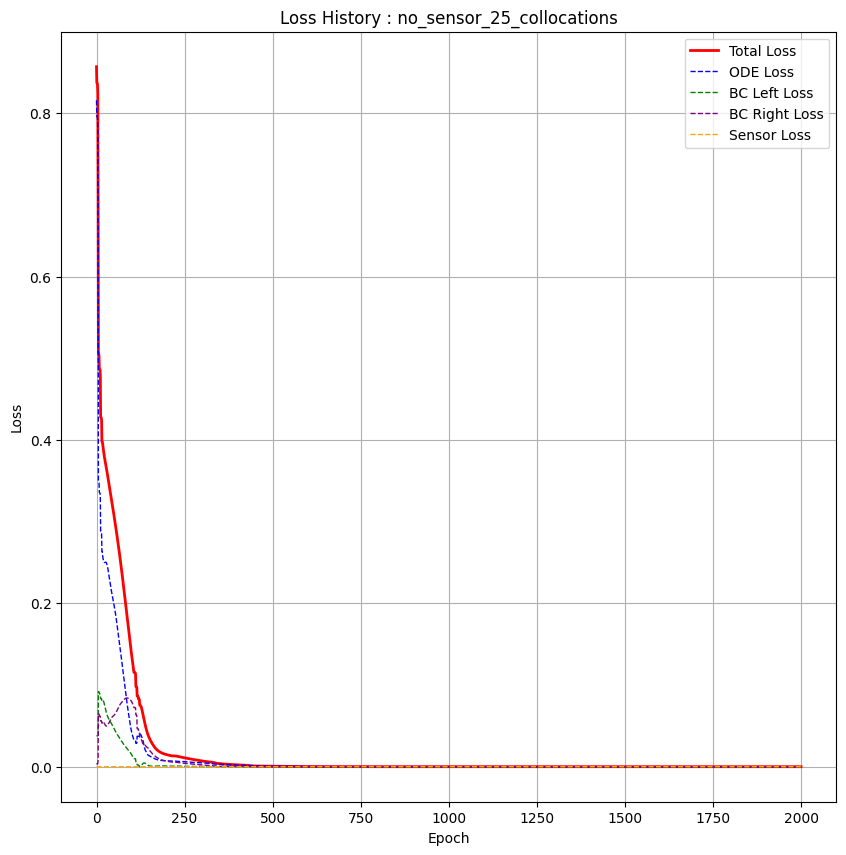

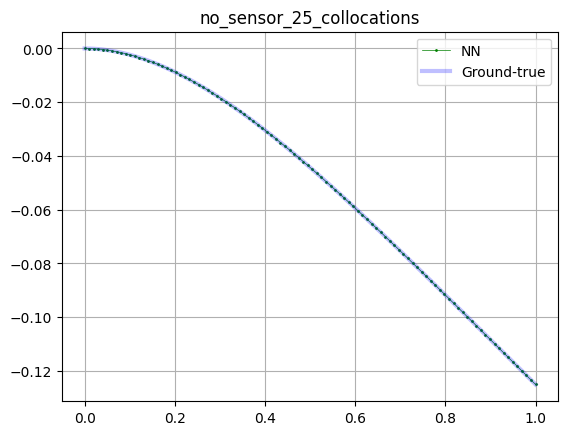

In [27]:
model = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 1],
)

create_scenario(
    scenario_name="no_sensor_25_collocations",
    opt={"L": 1, "data_size": 25, "lr": 1e-3, "epoch": 2000, "sensor_step": None},
    model=model,
)

---------------------------------------------------------------------------
Scenario little_sensor_25_collocations
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 4}
---------------------------------------------------------------------------
Model little_sensor_25_collocations Model size: 361
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-3): 3 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (4): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.1334335803985596, Loss sensor: 0.00526903523132205, Loss ODE: 1.1269519329071045, Loss BC Left: 0.0009281841339543462, Loss BC Right: 0.00028443773044273257
Epoch: 1

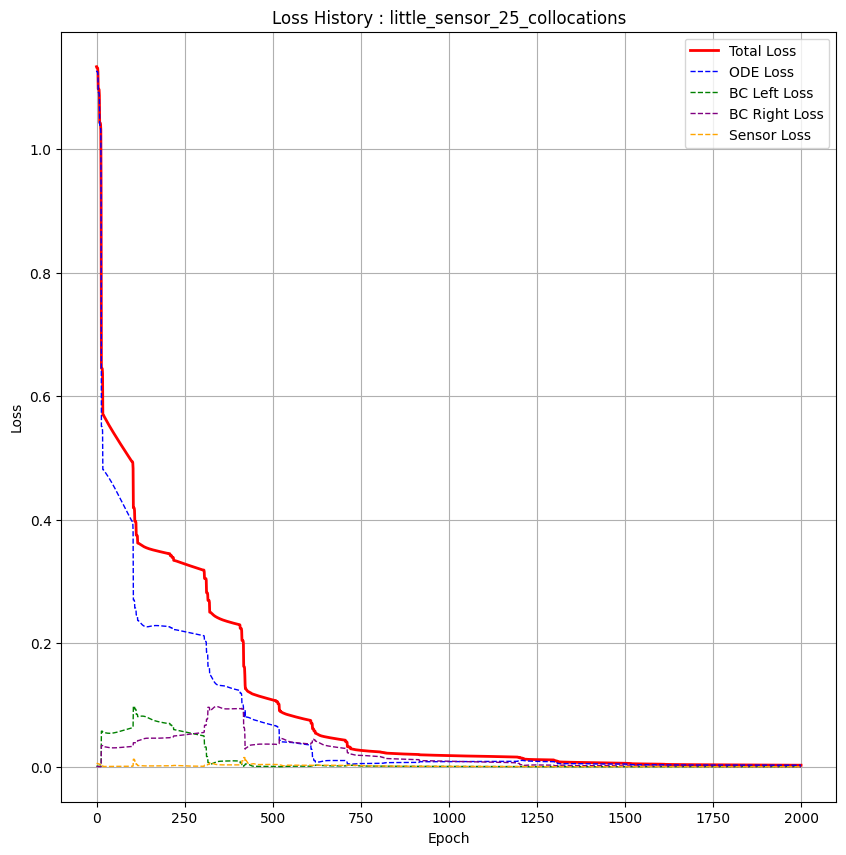

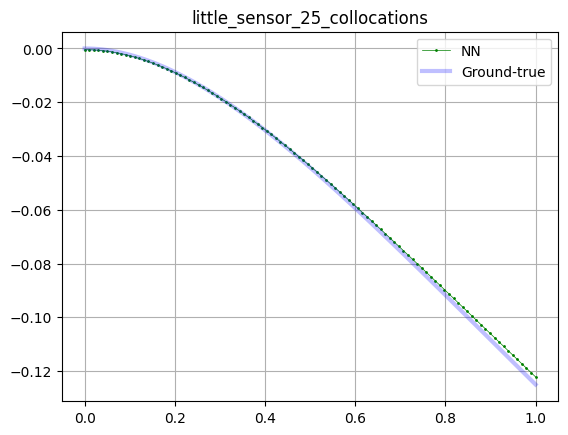

In [10]:
model2 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 10, 1],
)
create_scenario(
    scenario_name="little_sensor_25_collocations",
    model=model2,
    opt={
        "L": 1,
        "data_size": 25,
        "lr": 1e-4,
        "epoch": 2000,
        "sensor_step": 4,
    },
)

---------------------------------------------------------------------------
Scenario low_model_complexity
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model low_model_complexity Model size: 62
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.18301522731781, Loss sensor: 0.23479466140270233, Loss ODE: 0.7251282930374146, Loss BC Left: 0.2

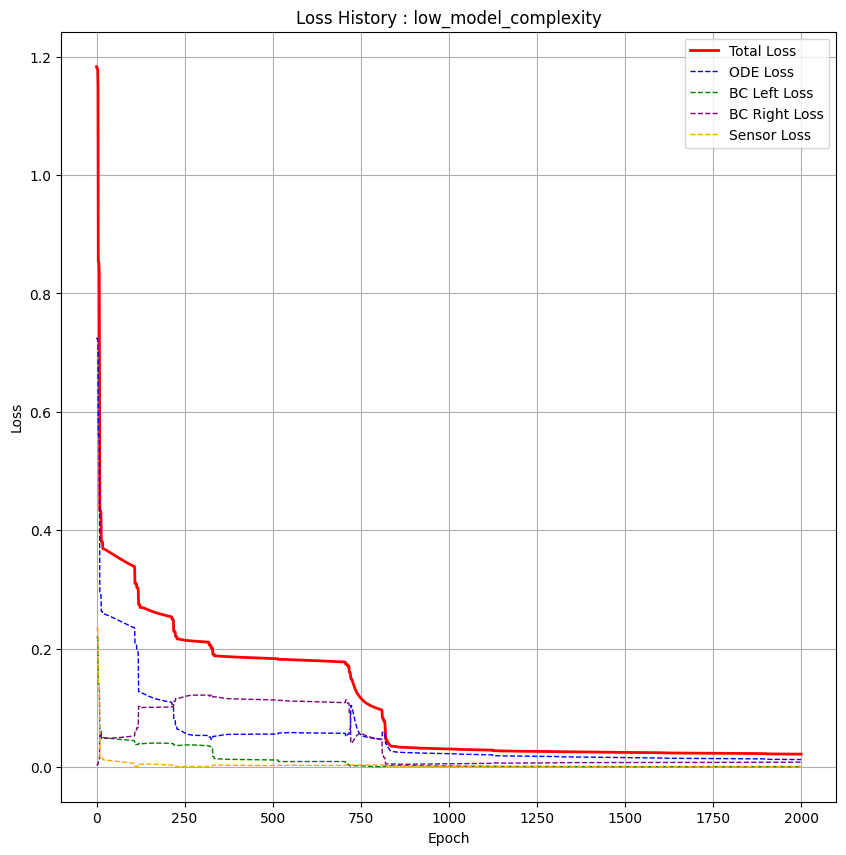

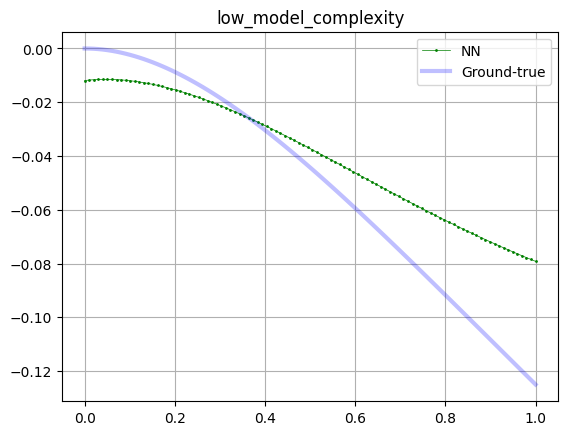

In [11]:
model3 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 3, 5, 5, 1],
)

create_scenario(
    scenario_name="low_model_complexity",
    opt={
        "L": 1,
        "data_size": 25,
        "lr": 1e-4,
        "epoch": 2000,
        "sensor_step": 5,
    },
    model=model3,
)

---------------------------------------------------------------------------
Scenario low_model_complexity_sigmoid
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model low_model_complexity_sigmoid Model size: 141
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (1): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.030507206916809, Loss sensor: 0.010934354737401009, Loss ODE: 0.9994155168533325, Loss BC Left: 0.020131565630435944, Loss BC Right: 2.5726852982188575e-05
Epoch: 100,

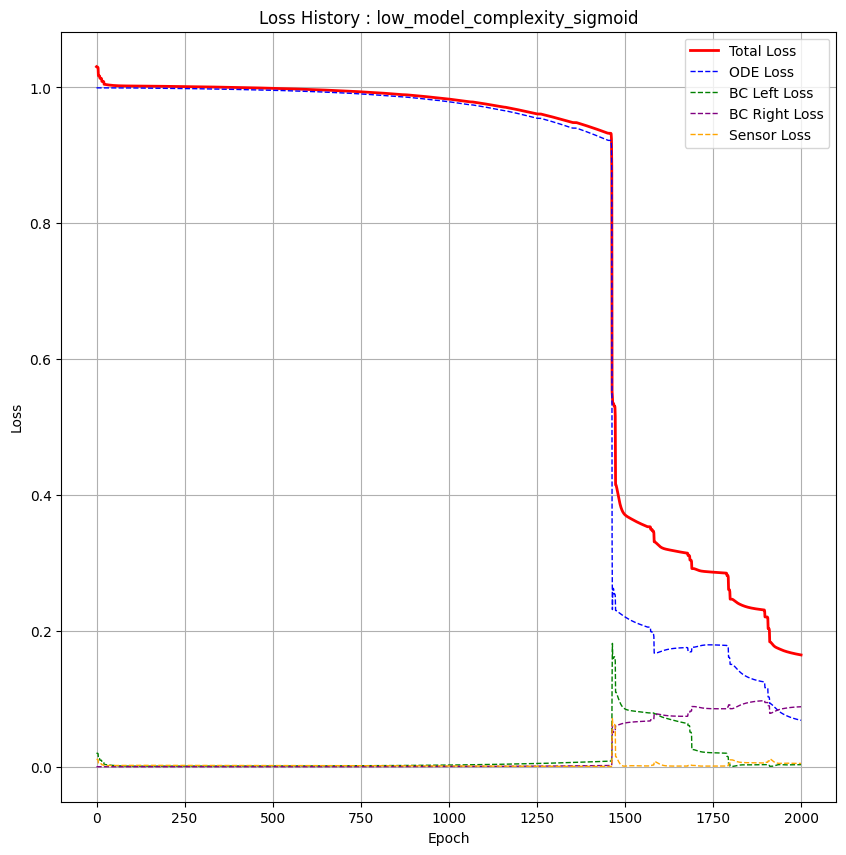

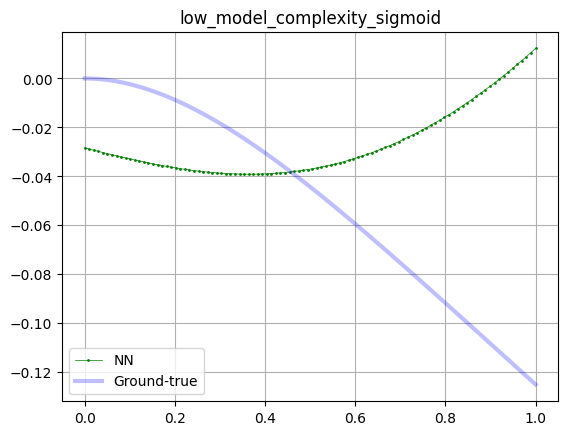

In [12]:
model4 = PolymorphicModel(
    activation_functions="sigmoid",
    model_architecture=[1, 10, 10, 1],
)

create_scenario(
    scenario_name="low_model_complexity_sigmoid",
    opt={
        "L": 1,
        "data_size": 25,
        "lr": 1e-4,
        "epoch": 2000,
        "sensor_step": 5,
    },
    model=model4,
)

---------------------------------------------------------------------------
Scenario tanh_activation
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 4000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model tanh_activation Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.9726143479347229, Loss sensor: 0.023490890860557556, Loss ODE: 0.9107199907302856, Loss BC Left: 0.034829627722501755, Loss BC Right: 0.00357383512891829
Epoch: 100, Loss: 0.34548065066337585, 

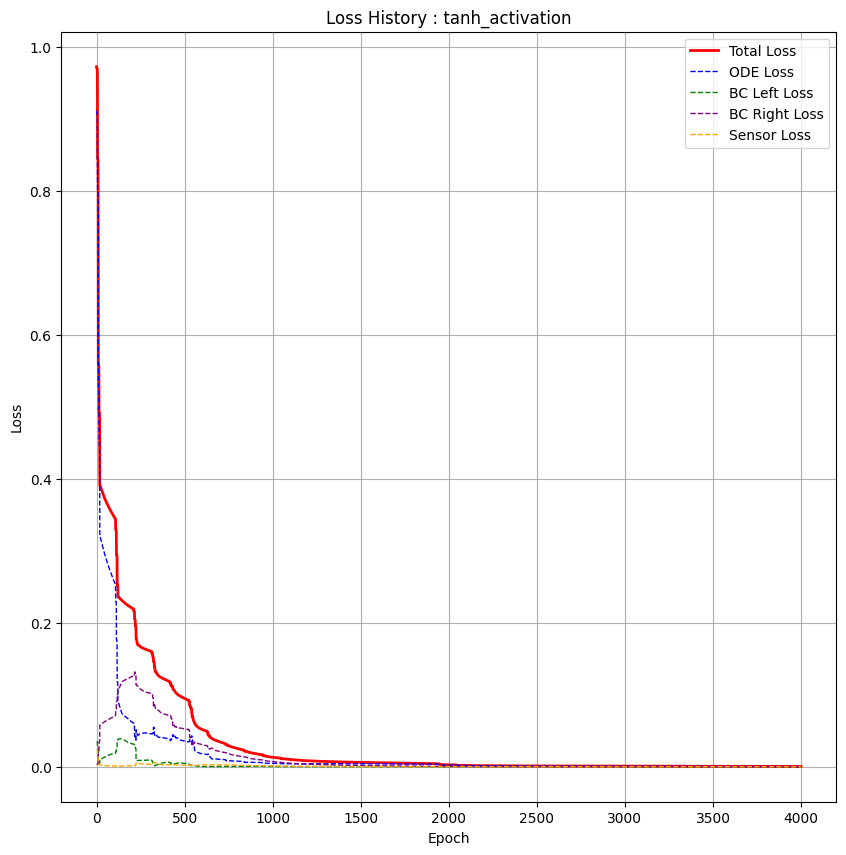

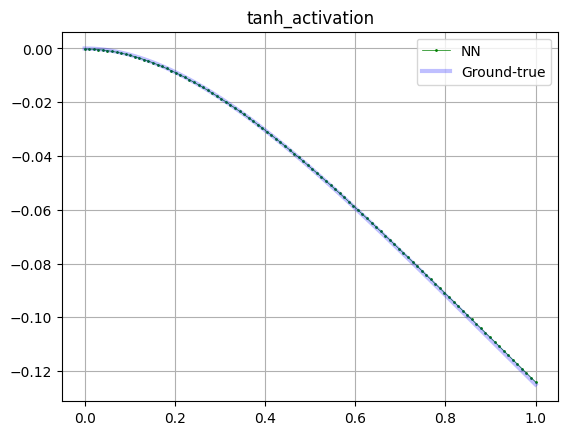

---------------------------------------------------------------------------
Scenario relu_activation
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 4000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model relu_activation Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.028321385383606, Loss sensor: 0.009068658575415611, Loss ODE: 1.0, Loss BC Left: 0.019252730533480644, Loss BC Right: 0.0
Epoch: 100, Loss: 1.0048505067825317, Loss sensor: 0.002787472680211067

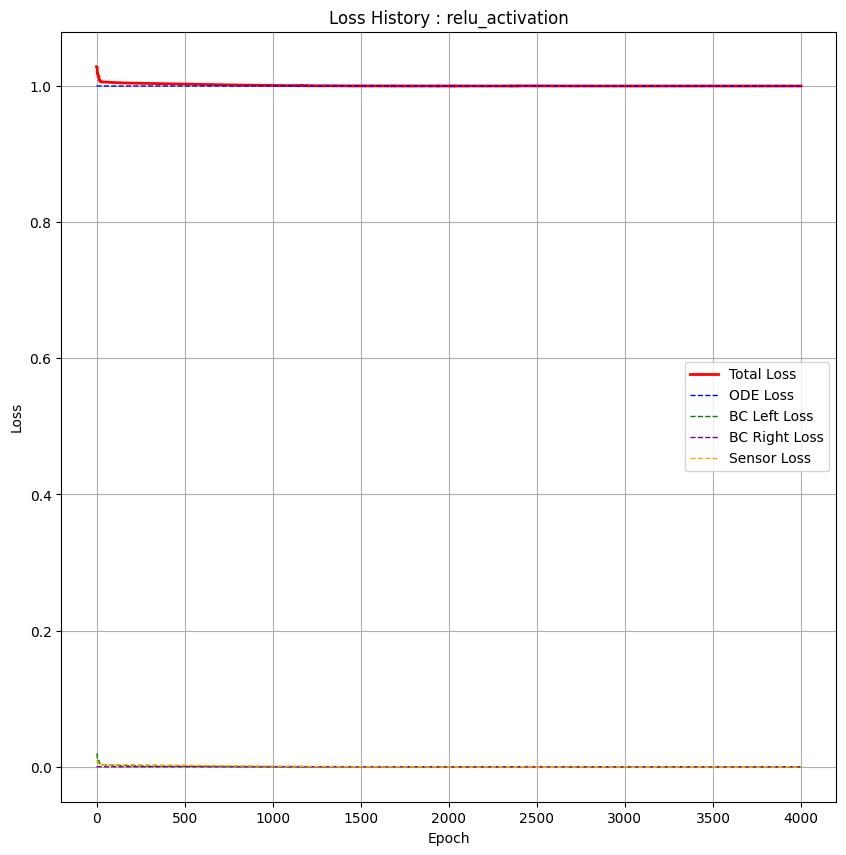

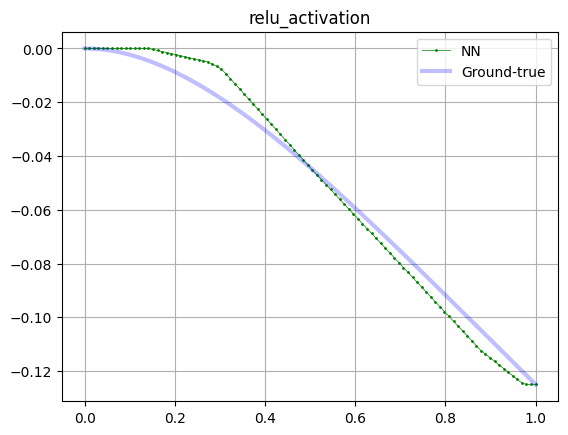

---------------------------------------------------------------------------
Scenario sigmoid_activation
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 4000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model sigmoid_activation Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.1704176664352417, Loss sensor: 0.10275765508413315, Loss ODE: 0.999821126461029, Loss BC Left: 0.06783867627382278, Loss BC Right: 1.3796693565382157e-07
Epoch: 100, Loss: 1.0039033

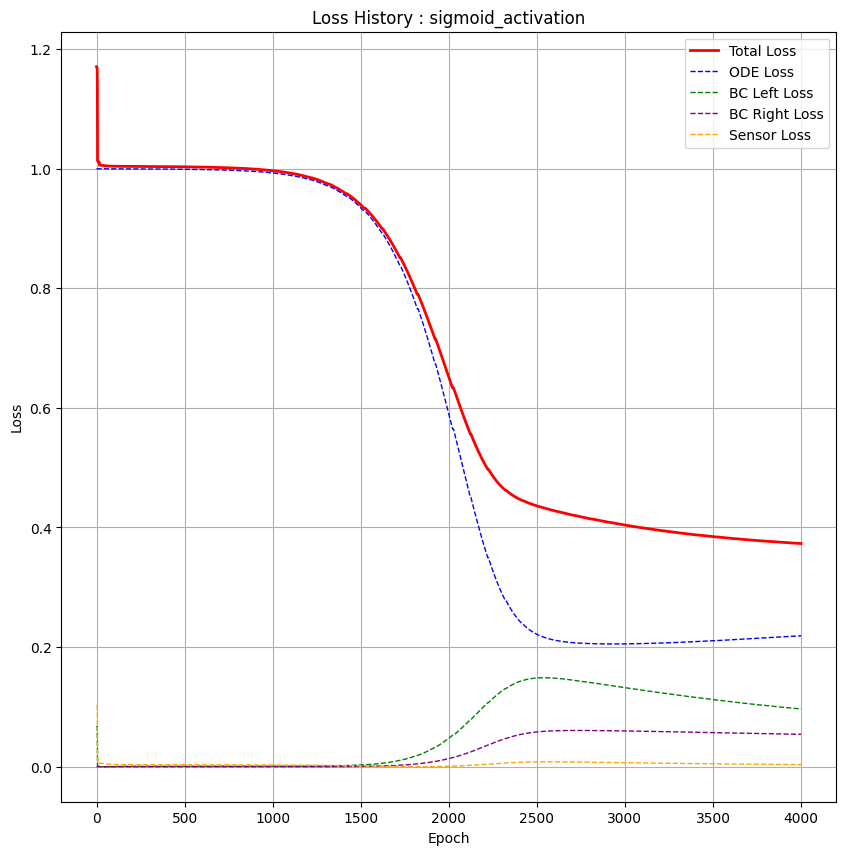

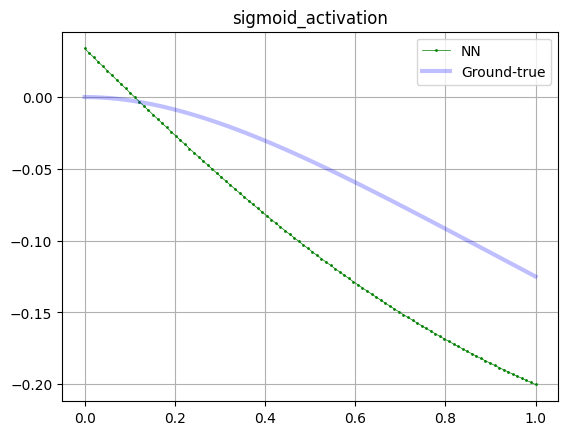

In [34]:
activations = [
    "tanh",
    "relu",
    "sigmoid",
]

for activation in activations:
    model = PolymorphicModel(
        activation_functions=activation,
        model_architecture=[1, 10, 10, 10, 1],
    )

    create_scenario(
        scenario_name=f"{activation}_activation",
        opt={
            "L": 1,
            "data_size": 25,
            "lr": 1e-4,
            "epoch": 4000,
            "sensor_step": 3,
        },
        model=model,
    )

---------------------------------------------------------------------------
Scenario optimized_model_capacity
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 25, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model optimized_model_capacity Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.7859613299369812, Loss sensor: 0.013033983297646046, Loss ODE: 0.7643276453018188,

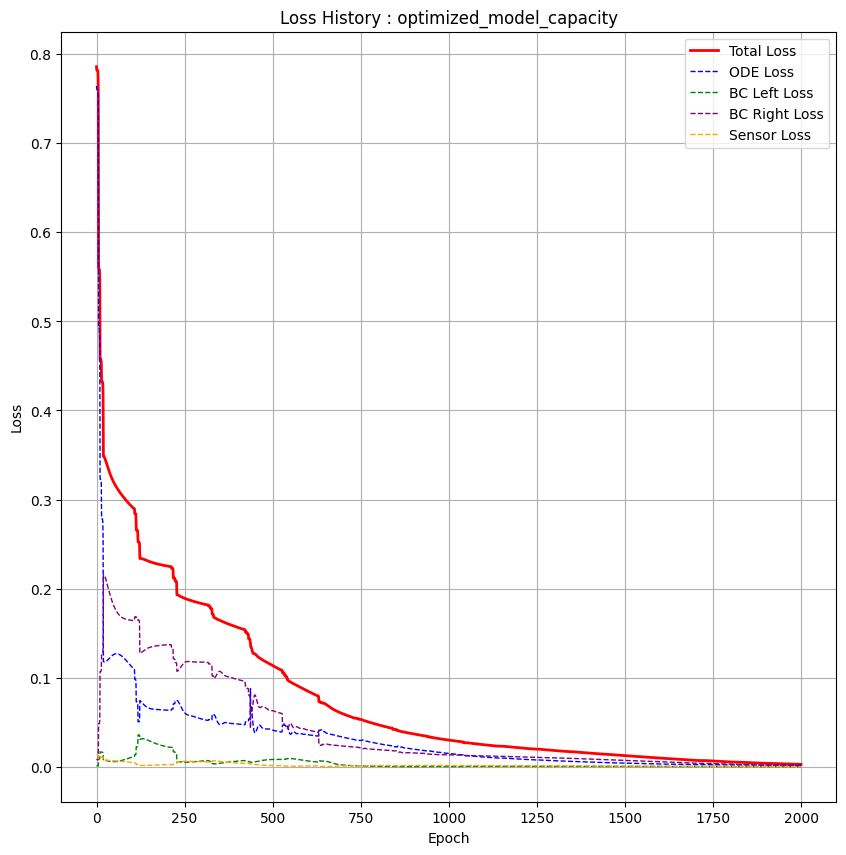

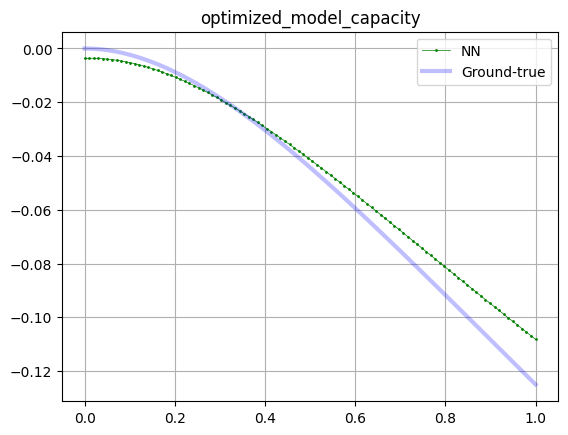

In [14]:
model6 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 15, 10, 15, 1],
)

create_scenario(
    scenario_name="optimized_model_capacity",
    opt={
        "L": 1,
        "data_size": 25,
        "lr": 1e-4,
        "epoch": 2000,
        "sensor_step": 3,
    },
    model=model6,
)

---------------------------------------------------------------------------
Scenario pure data driven 1000 epochs
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 0, 'lr': 1e-05, 'epoch': 1000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model pure data driven 1000 epochs Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.024427909404039383, Loss sensor: 0.024427909404039383, Loss ODE: 1.6243585348129272, Loss BC Left: nan, Loss BC Right: nan
Epoch: 100, Loss: 0.003009754465892911, Loss s

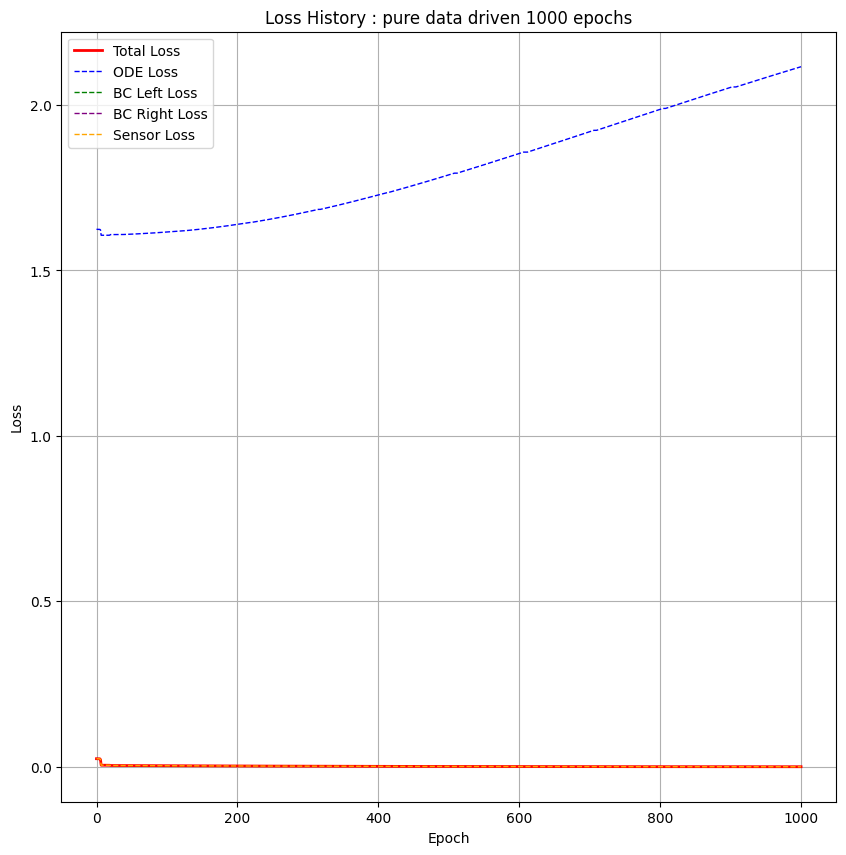

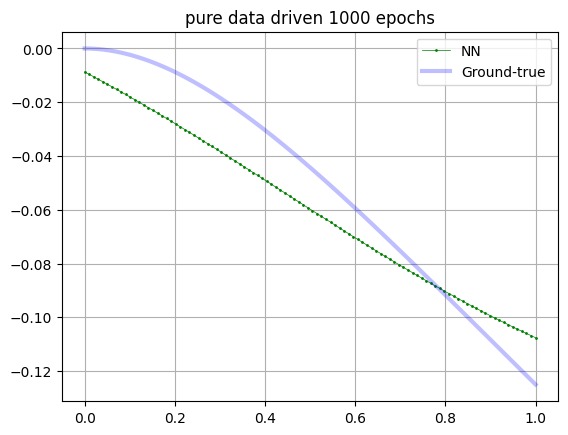

---------------------------------------------------------------------------
Scenario pure data driven 2000 epochs
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 0, 'lr': 1e-05, 'epoch': 2000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model pure data driven 2000 epochs Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.00020369821868371218, Loss sensor: 0.00020369821868371218, Loss ODE: 2.1162214279174805, Loss BC Left: nan, Loss BC Right: nan
Epoch: 100, Loss: 0.00012747033906634897, 

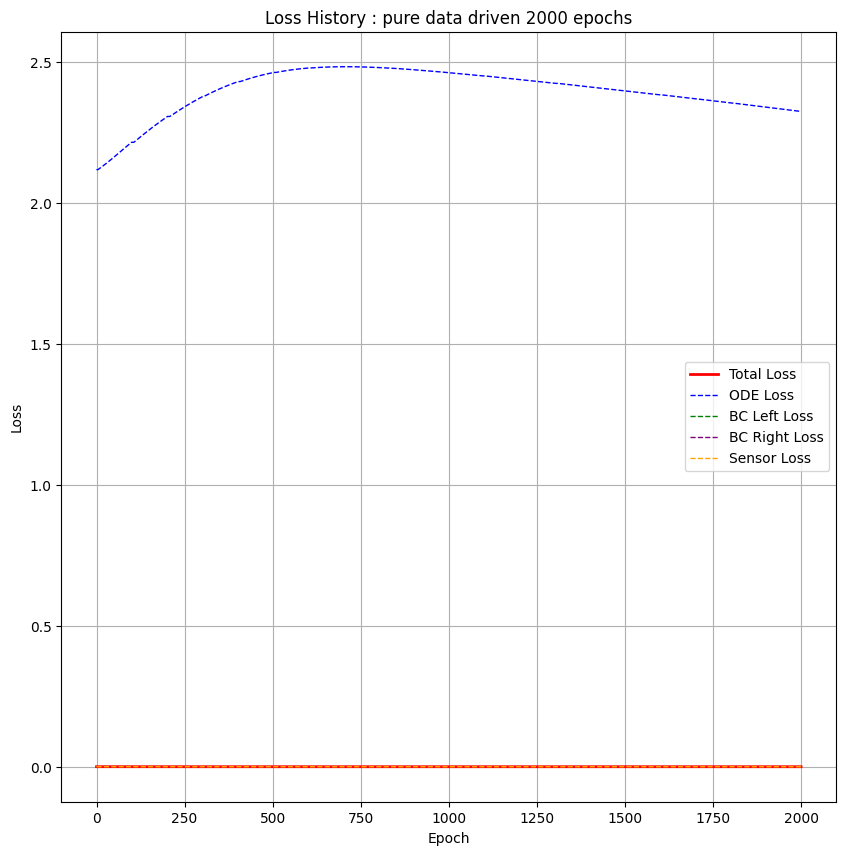

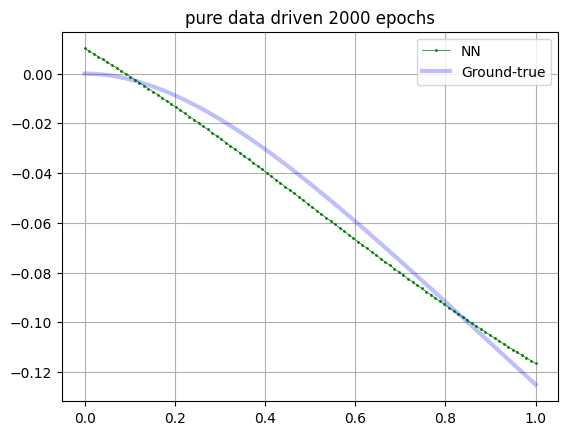

---------------------------------------------------------------------------
Scenario pure data driven 5000 epochs
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 0, 'lr': 1e-05, 'epoch': 5000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model pure data driven 5000 epochs Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 6.024049434927292e-05, Loss sensor: 6.024049434927292e-05, Loss ODE: 2.3233330249786377, Loss BC Left: nan, Loss BC Right: nan
Epoch: 100, Loss: 5.797125049866736e-05, Los

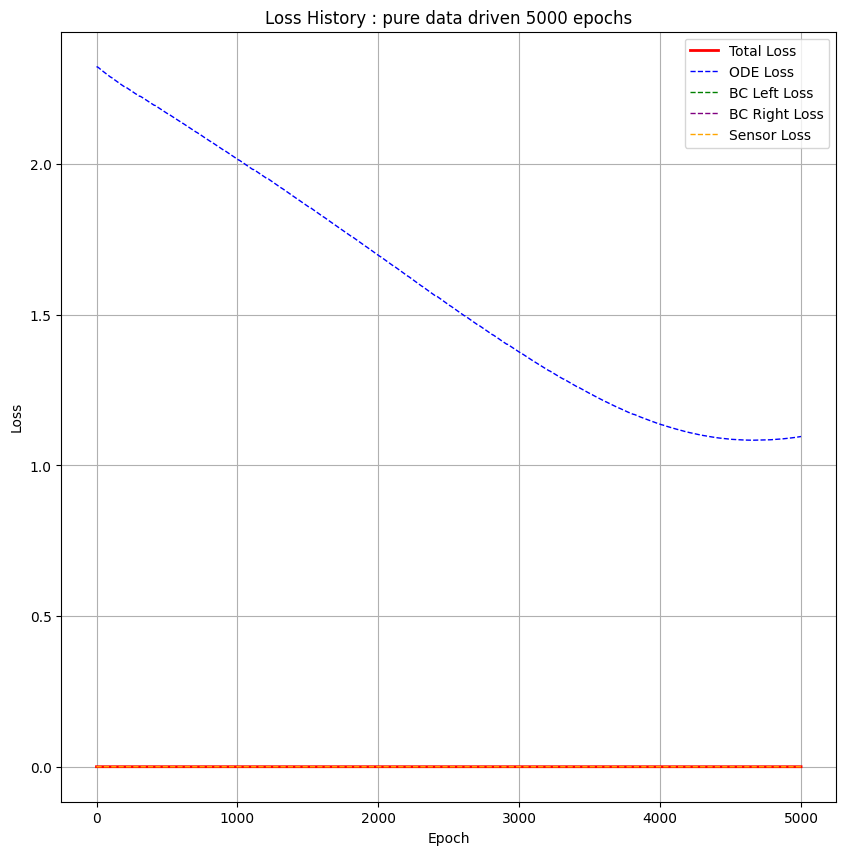

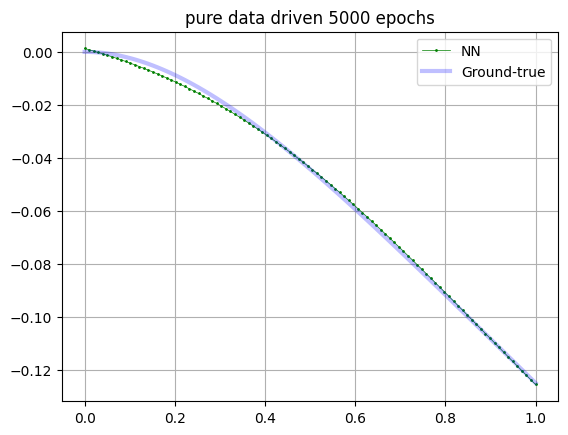

---------------------------------------------------------------------------
Scenario pure data driven 10000 epochs
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 0, 'lr': 1e-05, 'epoch': 10000, 'sensor_step': 5}
---------------------------------------------------------------------------
Model pure data driven 10000 epochs Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.7080767520383233e-06, Loss sensor: 1.7080767520383233e-06, Loss ODE: 1.0961107015609741, Loss BC Left: nan, Loss BC Right: nan
Epoch: 100, Loss: 1.6285239325952716e-0

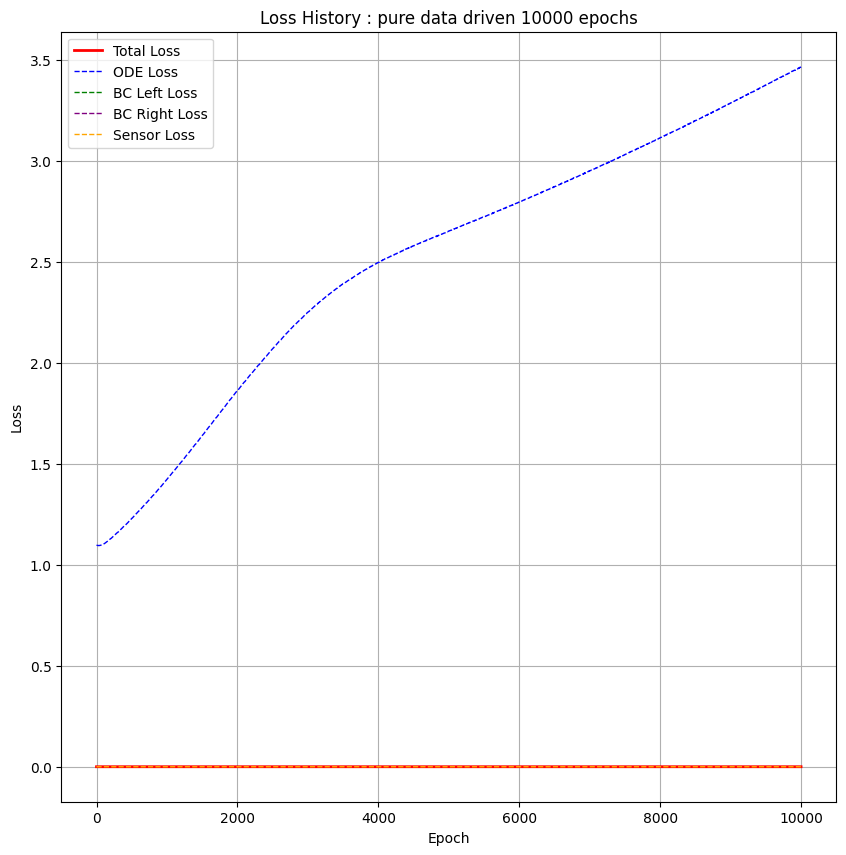

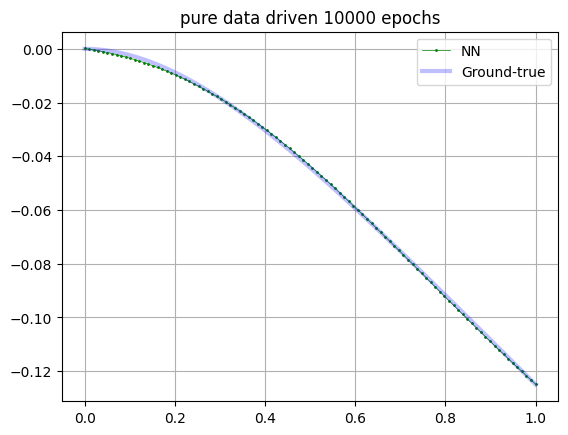

In [15]:
model7 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 1],
)

epochs = [1000, 2000, 5000, 10000]

for epoch in epochs:
    create_scenario(
        scenario_name=f"pure data driven {epoch} epochs",
        opt={
            "L": 1,
            "data_size": 0,
            "lr": 1e-5,
            "epoch": epoch,
            "sensor_step": 5,
        },
        model=model7,
    )

---------------------------------------------------------------------------
Scenario pure data driven 2000 epochs
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 0, 'lr': 0.001, 'epoch': 2000, 'sensor_step': 25}
---------------------------------------------------------------------------
Model pure data driven 2000 epochs Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 3.736385281172261e-07, Loss sensor: 3.736385281172261e-07, Loss ODE: 3.464885950088501, Loss BC Left: nan, Loss BC Right: nan
Epoch: 100, Loss: 2.203562559088823e-07, Los

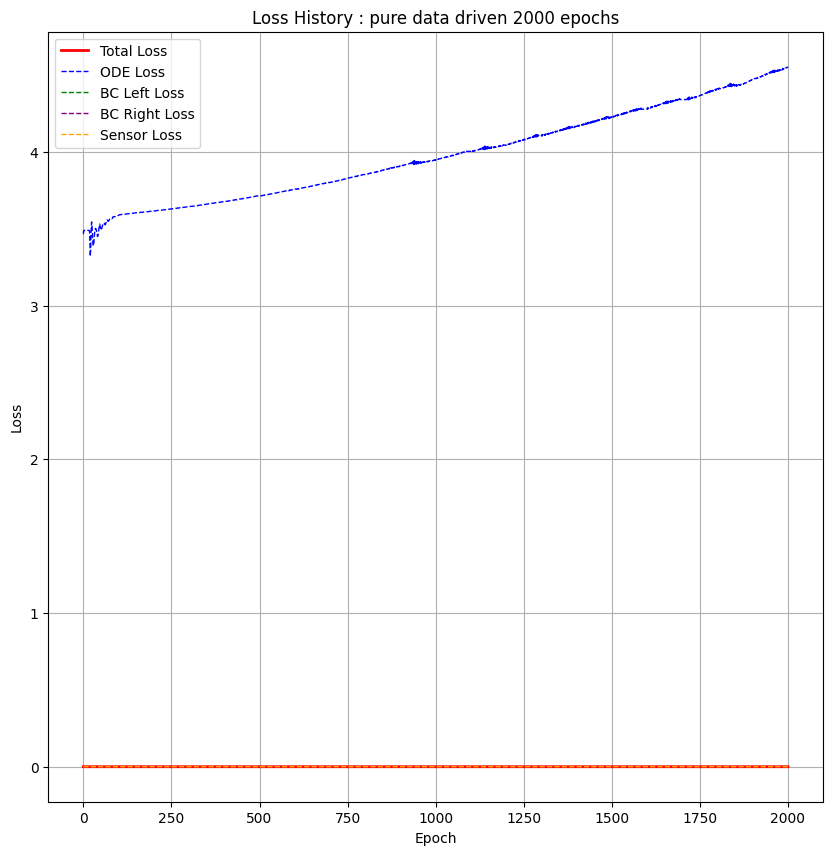

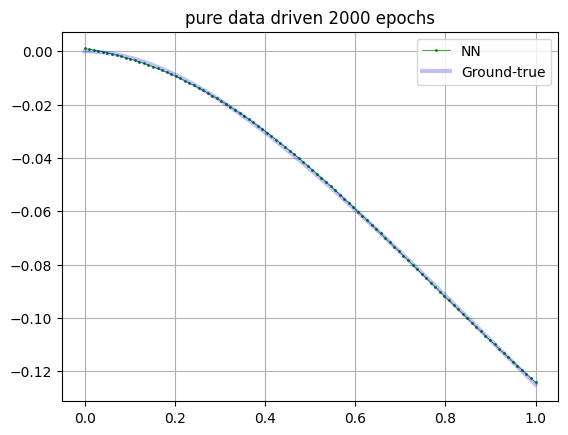

In [28]:
create_scenario(
    scenario_name=f"pure data driven {2000} epochs",
    opt={
        "L": 1,
        "data_size": 0,
        "lr": 1e-3,
        "epoch": 2000,
        "sensor_step": 25,
    },
    model=model7,
)

---------------------------------------------------------------------------
Scenario data driven + physics _ epoch 1000
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 1000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ epoch 1000 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.1619043350219727, Loss sensor: 0.050611402839422226, Loss ODE: 0.9953393340110779, Loss BC Left: 0.10991259664297104, Loss BC Right: 0.006041029468178749
E

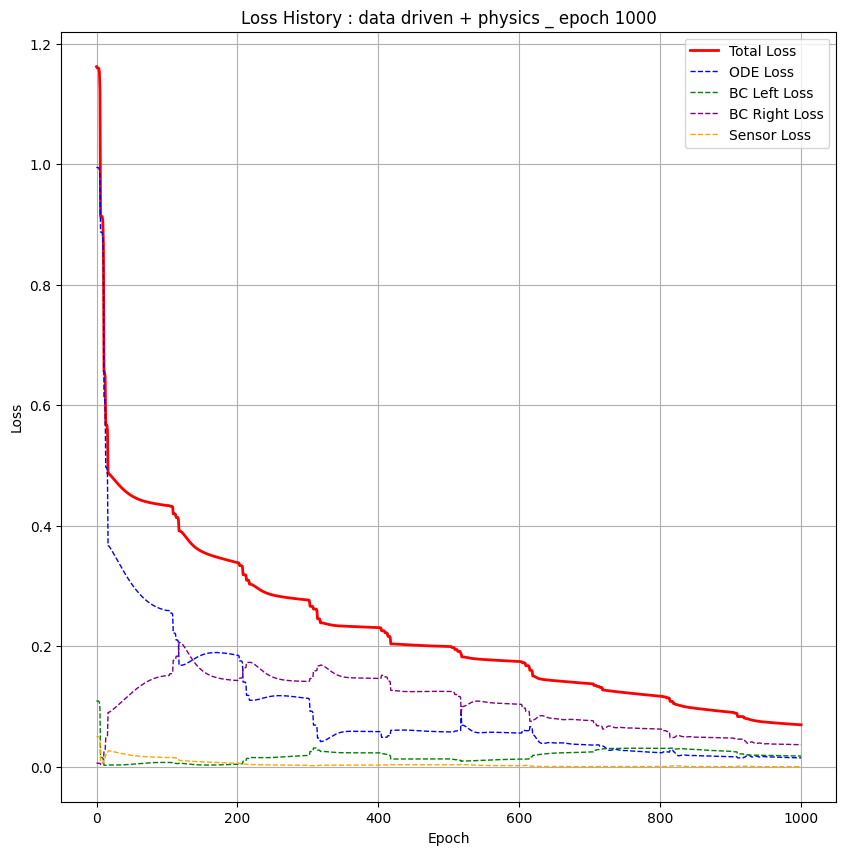

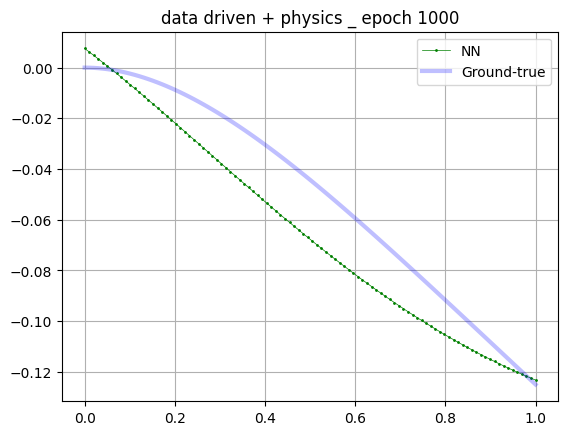

---------------------------------------------------------------------------
Scenario data driven + physics _ epoch 2000
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ epoch 2000 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.069669708609581, Loss sensor: 0.00020336848683655262, Loss ODE: 0.014862439595162868, Loss BC Left: 0.017899449914693832, Loss BC Right: 0.0367044508457183

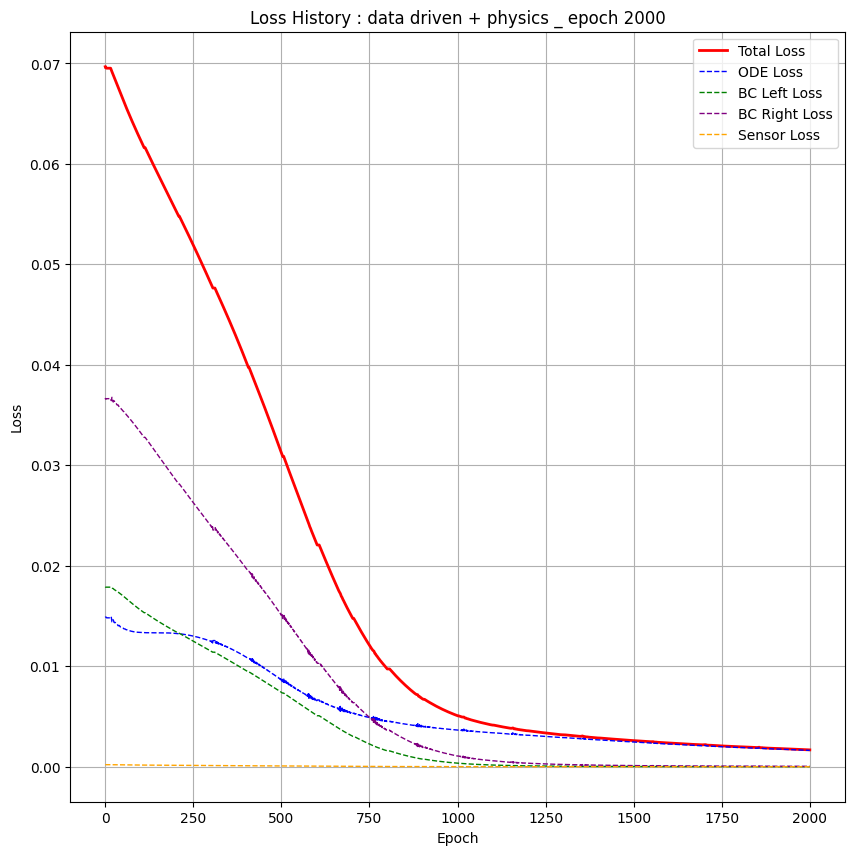

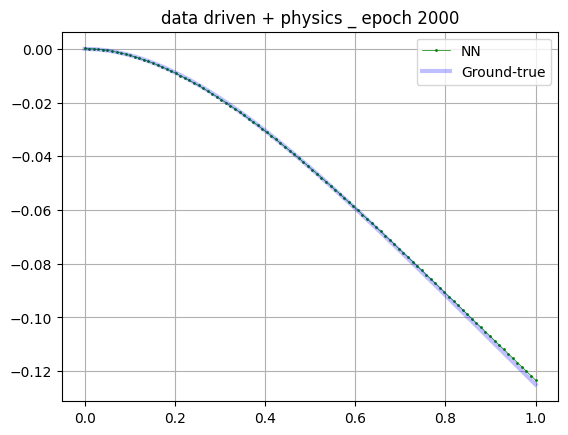

---------------------------------------------------------------------------
Scenario data driven + physics _ epoch 3000
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ epoch 3000 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.001676094252616167, Loss sensor: 9.070502642316569e-07, Loss ODE: 0.001626241602934897, Loss BC Left: 6.6741922637447715e-06, Loss BC Right: 4.227136741974

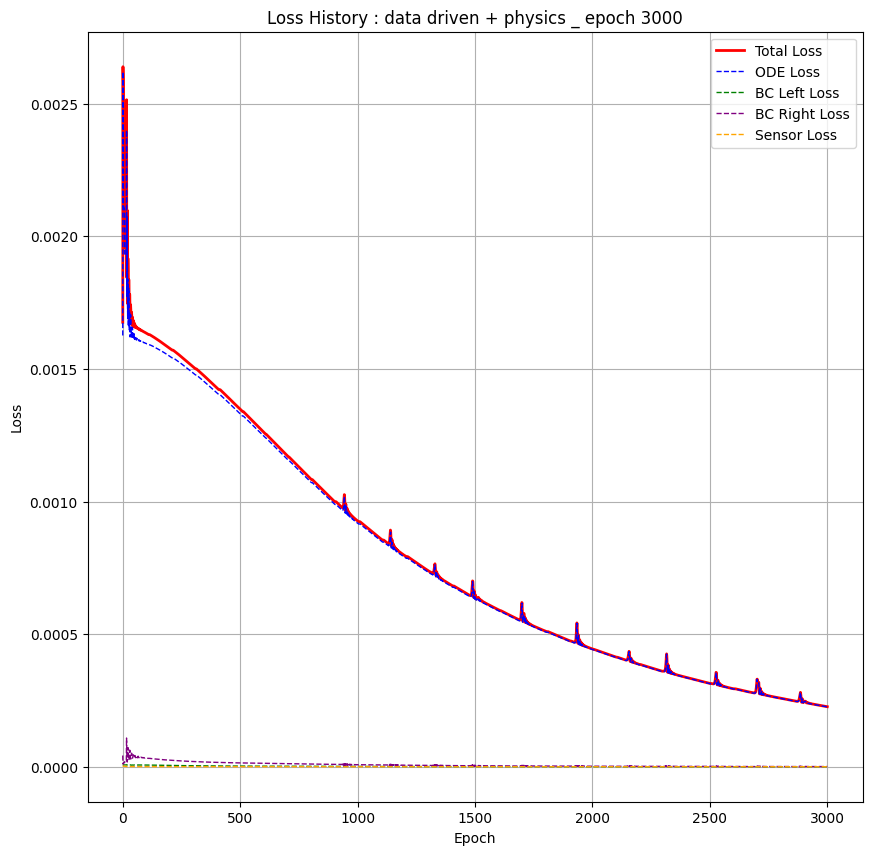

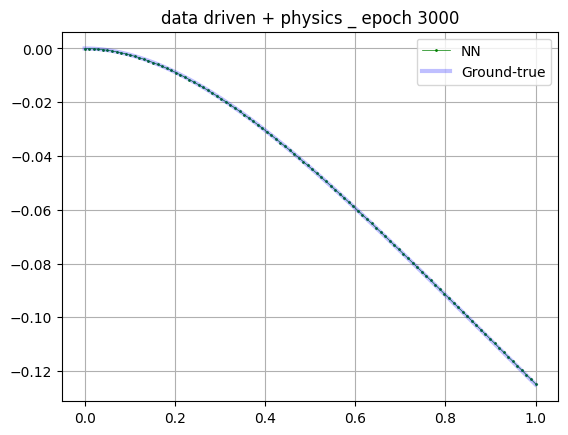

---------------------------------------------------------------------------
Scenario data driven + physics _ epoch 4000
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 4000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ epoch 4000 Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.00022623843688052148, Loss sensor: 1.94859470781239e-08, Loss ODE: 0.0002255764848086983, Loss BC Left: 1.5590273960697232e-08, Loss BC Right: 6.2688792468

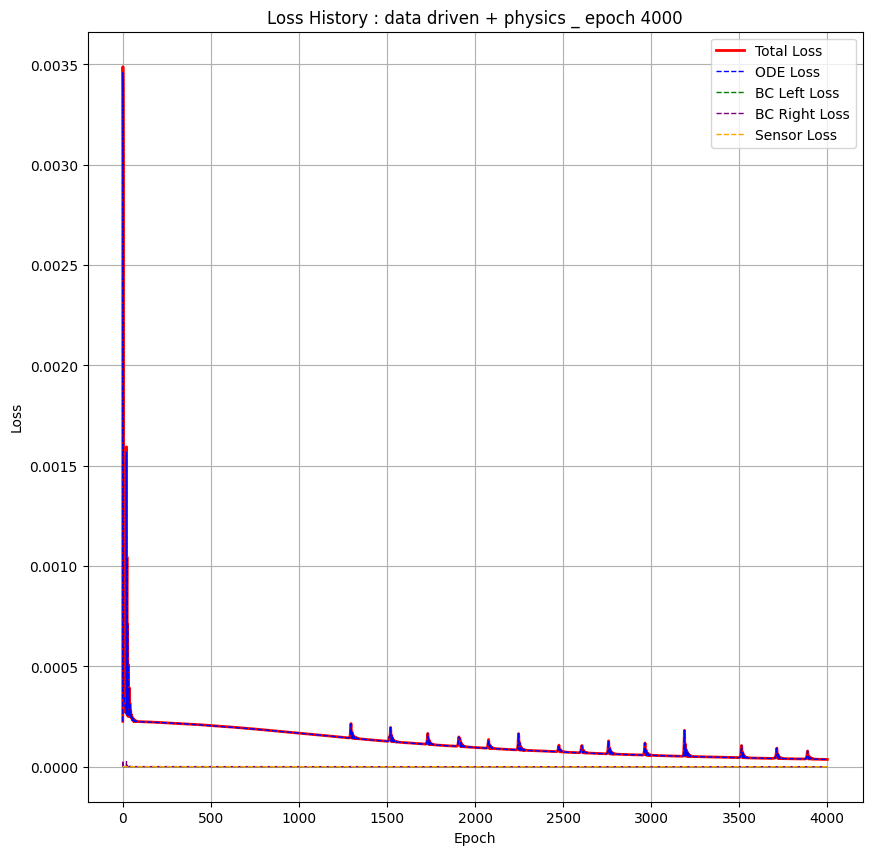

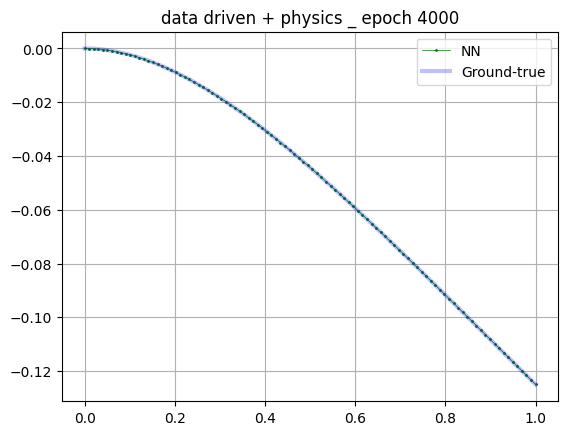

In [16]:
model8 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 10, 10, 10, 1],
)

create_scenario(
    scenario_name="data driven + physics _ epoch 1000",
    opt={
        "L": 1,
        "data_size": 50,
        "lr": 1e-4,
        "epoch": 1000,
        "sensor_step": 3,
    },
    model=model8,
)

create_scenario(
    scenario_name="data driven + physics _ epoch 2000",
    opt={
        "L": 1,
        "data_size": 50,
        "lr": 1e-4,
        "epoch": 2000,
        "sensor_step": 3,
    },
    model=model8,
)

create_scenario(
    scenario_name="data driven + physics _ epoch 3000",
    opt={
        "L": 1,
        "data_size": 50,
        "lr": 1e-4,
        "epoch": 3000,
        "sensor_step": 3,
    },
    model=model8,
)

create_scenario(
    scenario_name="data driven + physics _ epoch 4000",
    opt={
        "L": 1,
        "data_size": 50,
        "lr": 1e-4,
        "epoch": 4000,
        "sensor_step": 3,
    },
    model=model8,
)

---------------------------------------------------------------------------
Scenario data driven + physics _ lr 0.1
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.1, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ lr 0.1 Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.0204191207885742, Loss sensor: 0.0039416030049324036, Loss ODE: 1.0078635

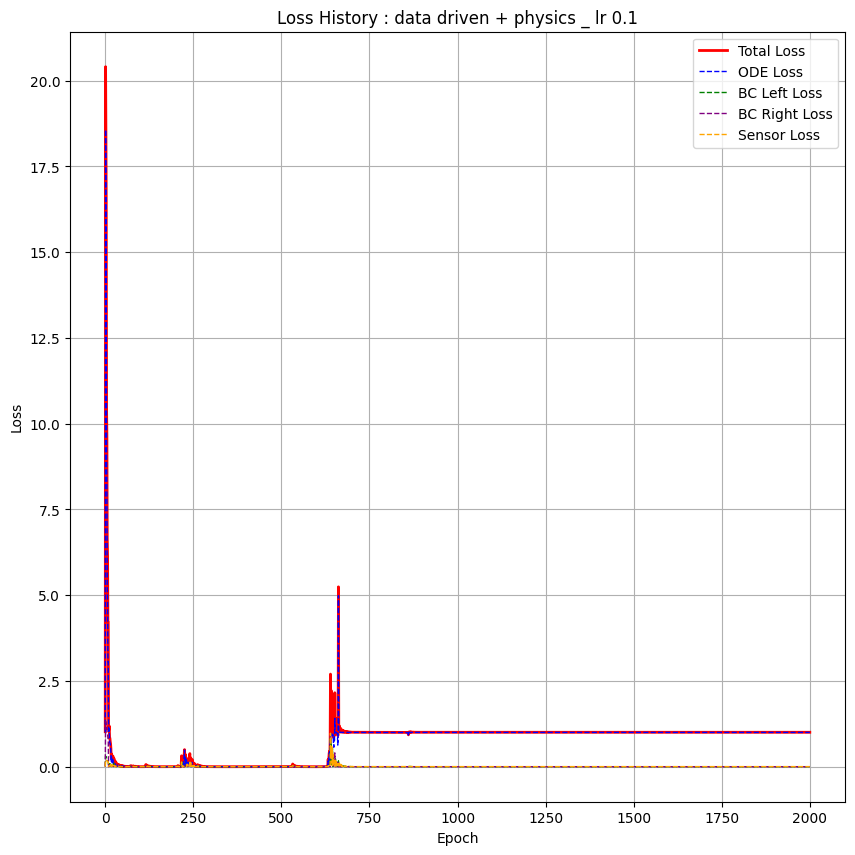

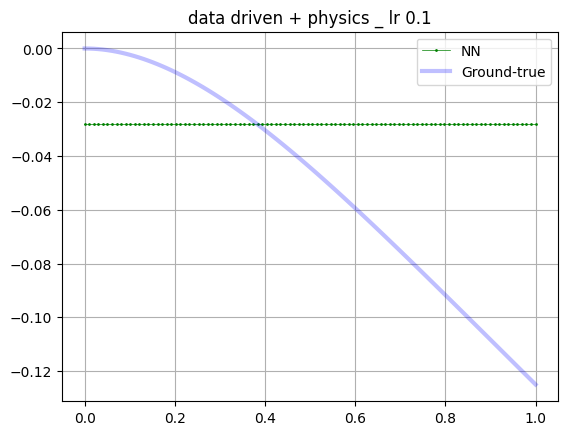

---------------------------------------------------------------------------
Scenario data driven + physics _ lr 0.01
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.01, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ lr 0.01 Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.004270076751709, Loss sensor: 0.00347248581238091, Loss ODE: 1.0000003

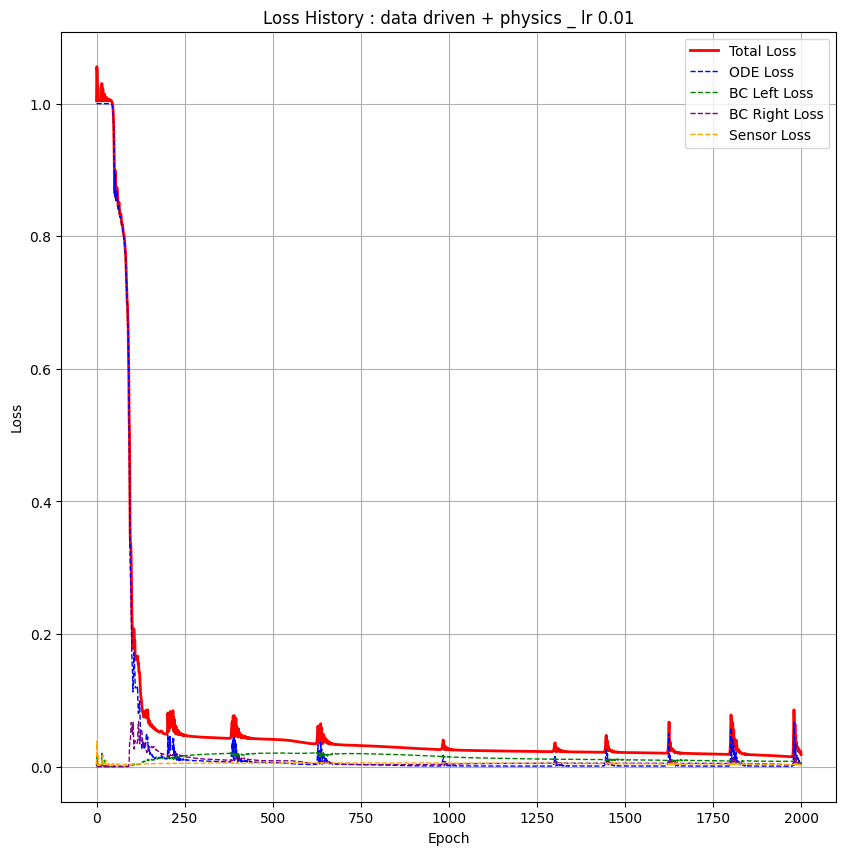

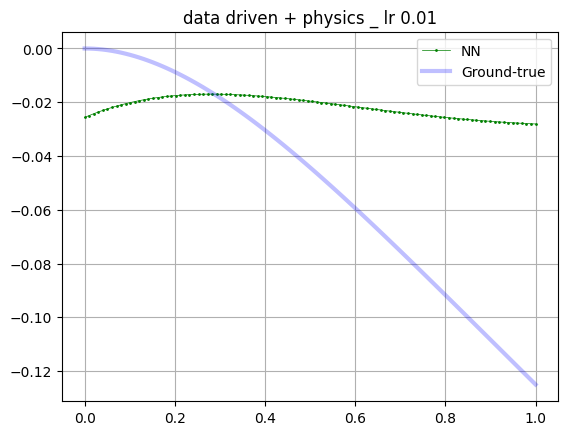

---------------------------------------------------------------------------
Scenario data driven + physics _ lr 0.001
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.001, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ lr 0.001 Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.022196412086486816, Loss sensor: 0.0035534948110580444, Loss ODE: 0

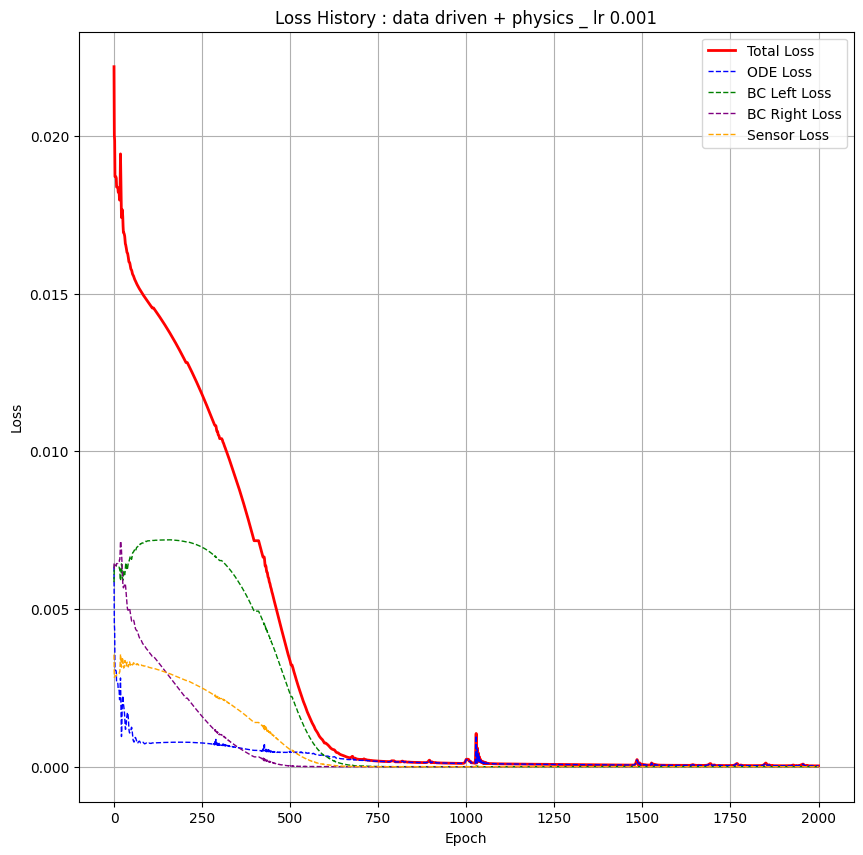

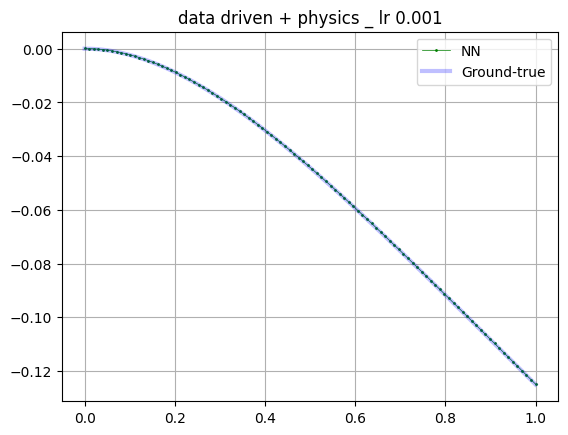

---------------------------------------------------------------------------
Scenario data driven + physics _ lr 0.0001
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ lr 0.0001 Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 2.7559426598600112e-05, Loss sensor: 9.789109078894853e-09, Loss O

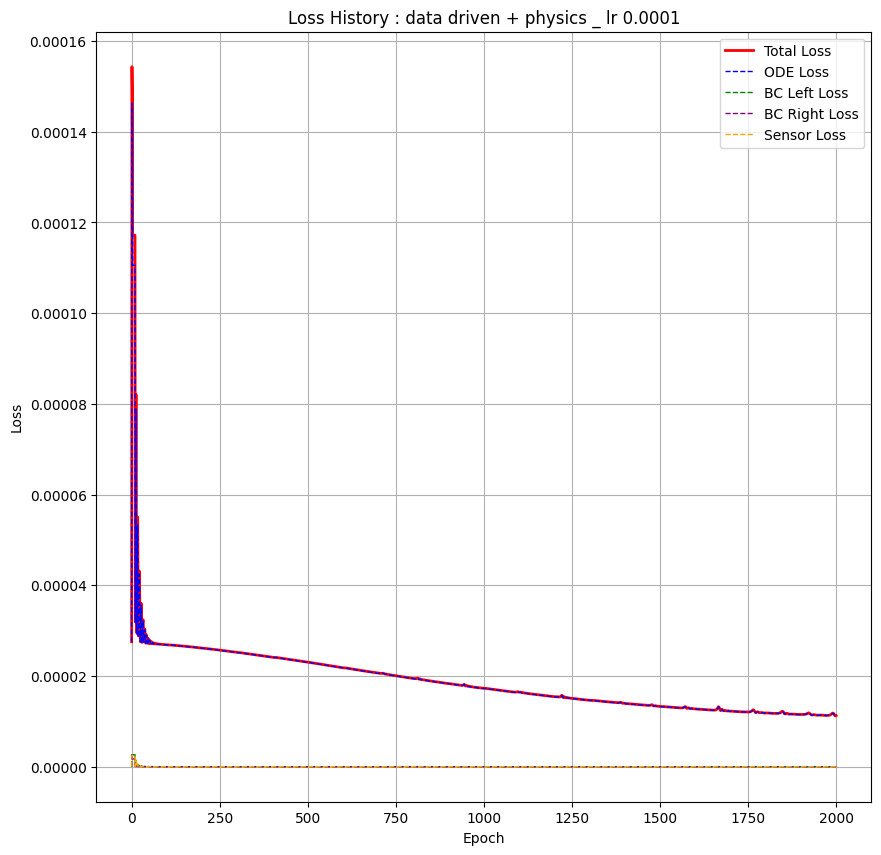

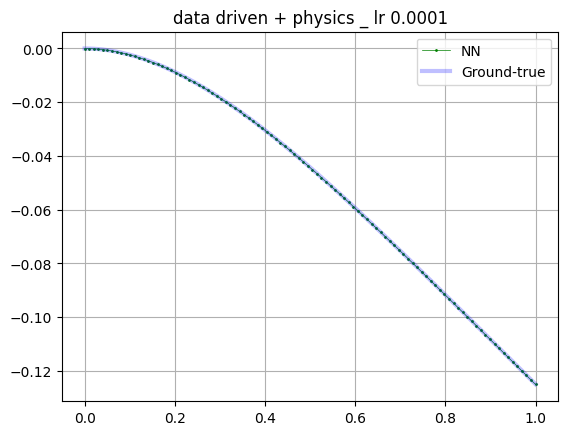

---------------------------------------------------------------------------
Scenario data driven + physics _ lr 1e-05
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 1e-05, 'epoch': 2000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model data driven + physics _ lr 1e-05 Model size: 371
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.1317596545268316e-05, Loss sensor: 5.741821684779325e-09, Loss ODE:

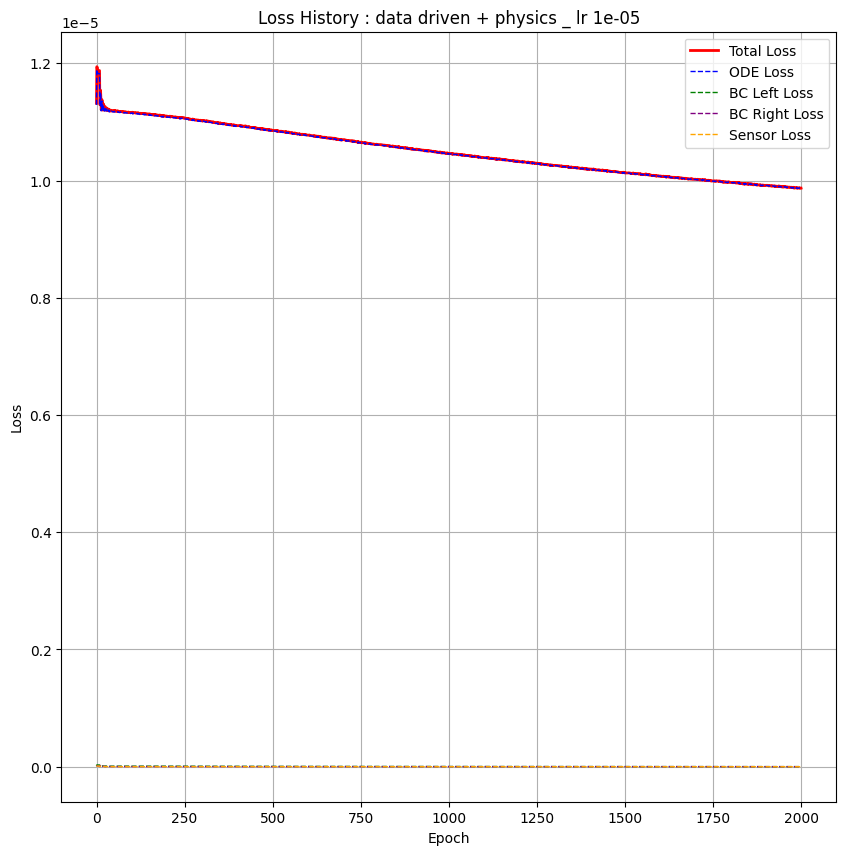

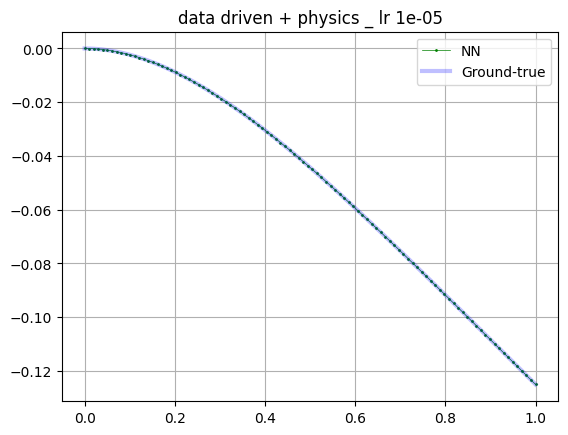

In [17]:
lr_test = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

model9 = PolymorphicModel(
    activation_functions="tanh",
    model_architecture=[1, 15, 10, 15, 1],
)

for lr in lr_test:
    create_scenario(
        scenario_name=f"data driven + physics _ lr {lr}",
        opt={
            "L": 1,
            "data_size": 50,
            "lr": lr,
            "epoch": 2000,
            "sensor_step": 3,
        },
        model=model9,
    )

---------------------------------------------------------------------------
Scenario low_model_[1, 5, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model low_model_[1, 5, 1] Model size: 16
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 2.6778454780578613, Loss sensor: 0.6225191950798035, Loss ODE: 1.4945480823516846, Loss BC Left: 0.49316561222076416, Loss BC Right: 0.06761252880096436
Epoch: 100, Loss: 0.4817180633544922, Loss sensor: 0.0130611015483737, Loss ODE: 0.295674204826355, Loss BC Left: 0.14320753514766693, Loss BC

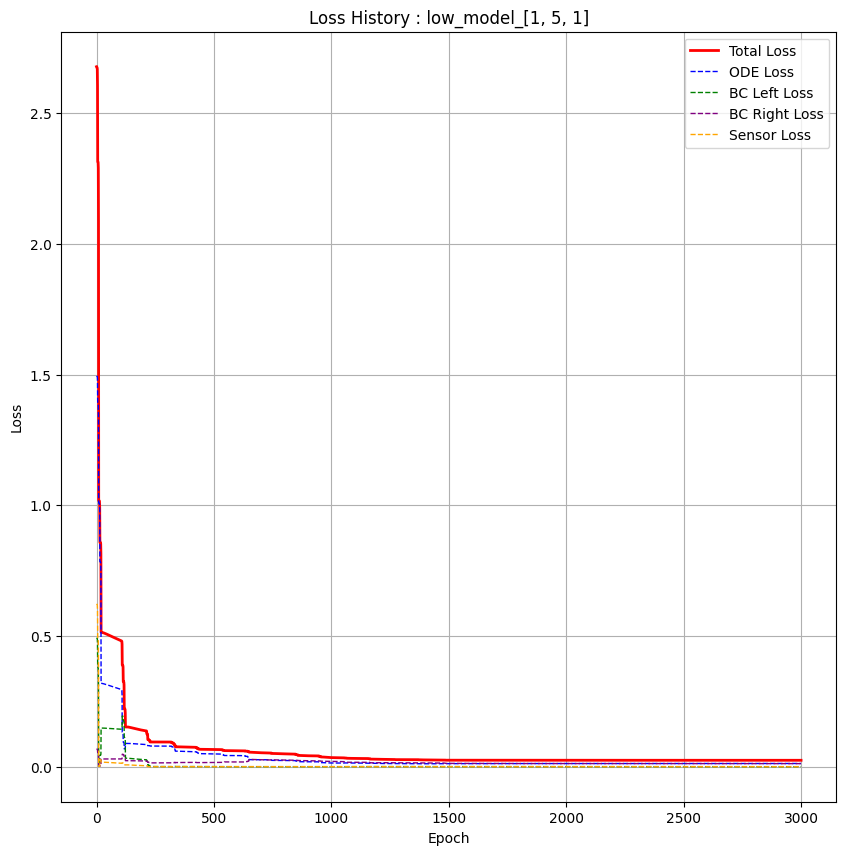

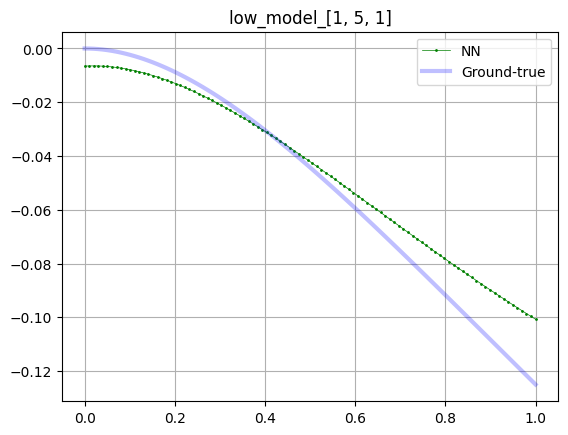

---------------------------------------------------------------------------
Scenario low_model_[1, 5, 5, 5, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model low_model_[1, 5, 5, 5, 1] Model size: 76
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.4212123155593872, Loss sensor: 0.05881137773394585, Loss ODE: 1.3026028871536255, Loss BC Left: 0.05427509546279907, Loss BC Right: 0.0055228895507752895
Epoch: 100, Loss: 0.3708

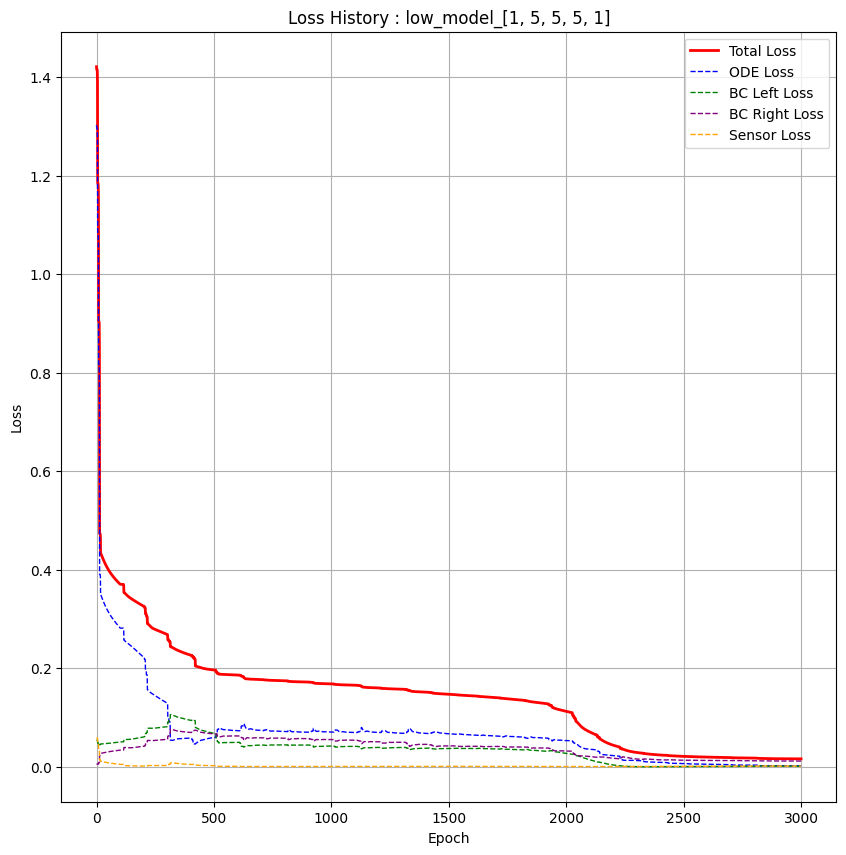

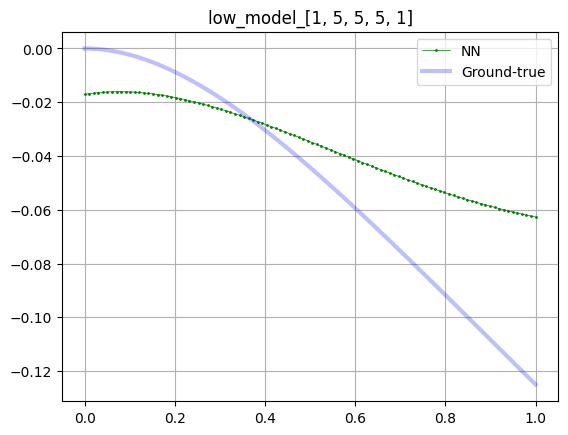

---------------------------------------------------------------------------
Scenario low_model_[1, 5, 5, 5, 5, 5, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model low_model_[1, 5, 5, 5, 5, 5, 1] Model size: 136
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Tanh()
  )
  (1-4): 4 x Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Tanh()
  )
  (5): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.3560854196548462, Loss sensor: 0.2529435455799103, Loss ODE: 0.8649700880050659, Loss BC Left: 0.23369795083999634, Loss BC Right: 0.004473813809454441
Epoch: 100, L

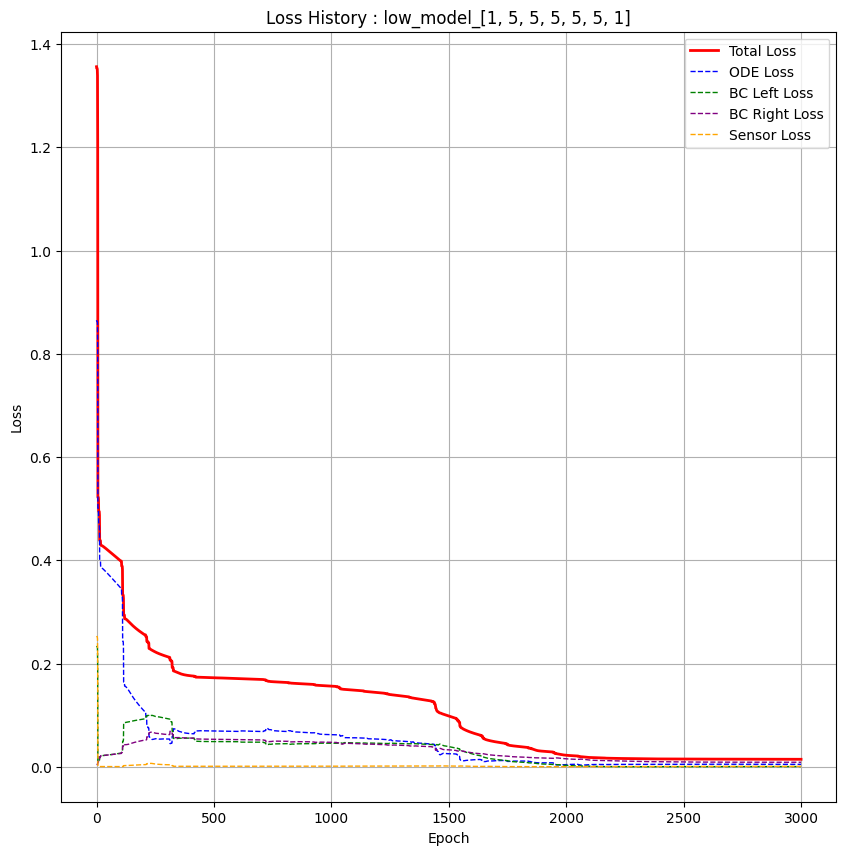

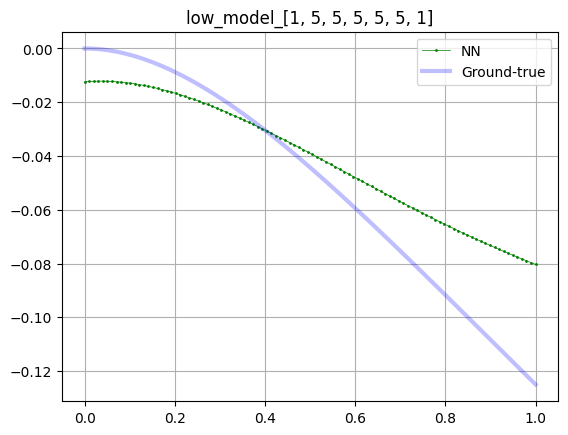

---------------------------------------------------------------------------
Scenario mid_model_[1, 10, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model mid_model_[1, 10, 1] Model size: 31
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 2.704596757888794, Loss sensor: 0.05597982183098793, Loss ODE: 1.894505500793457, Loss BC Left: 0.45569780468940735, Loss BC Right: 0.29841381311416626
Epoch: 100, Loss: 0.35319244861602783, Loss sensor: 0.0014224386541172862, Loss ODE: 0.285660058259964, Loss BC Left: 0.018831297755241394,

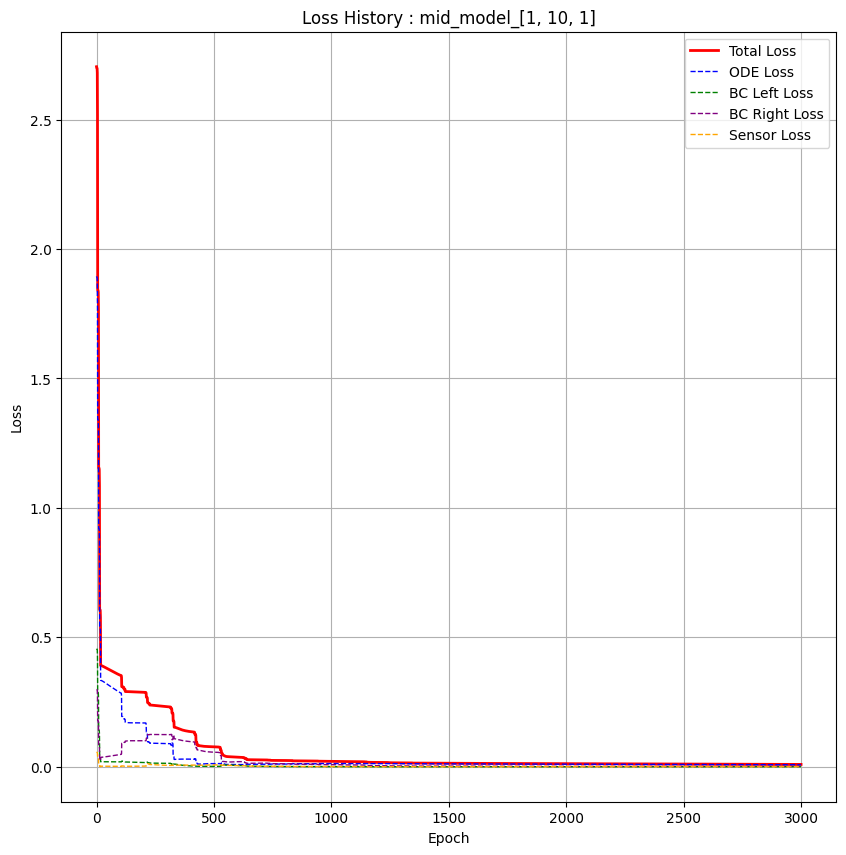

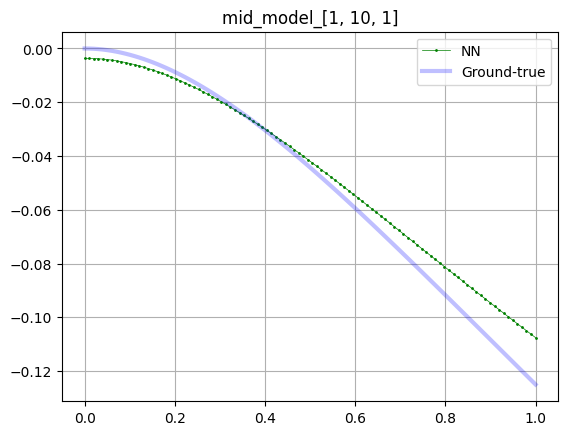

---------------------------------------------------------------------------
Scenario mid_model_[1, 10, 10, 10, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model mid_model_[1, 10, 10, 10, 1] Model size: 251
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.9688515067100525, Loss sensor: 0.023490890860557556, Loss ODE: 0.9069571495056152, Loss BC Left: 0.034829627722501755, Loss BC Right: 0.00357383512891829
Epoch: 100, L

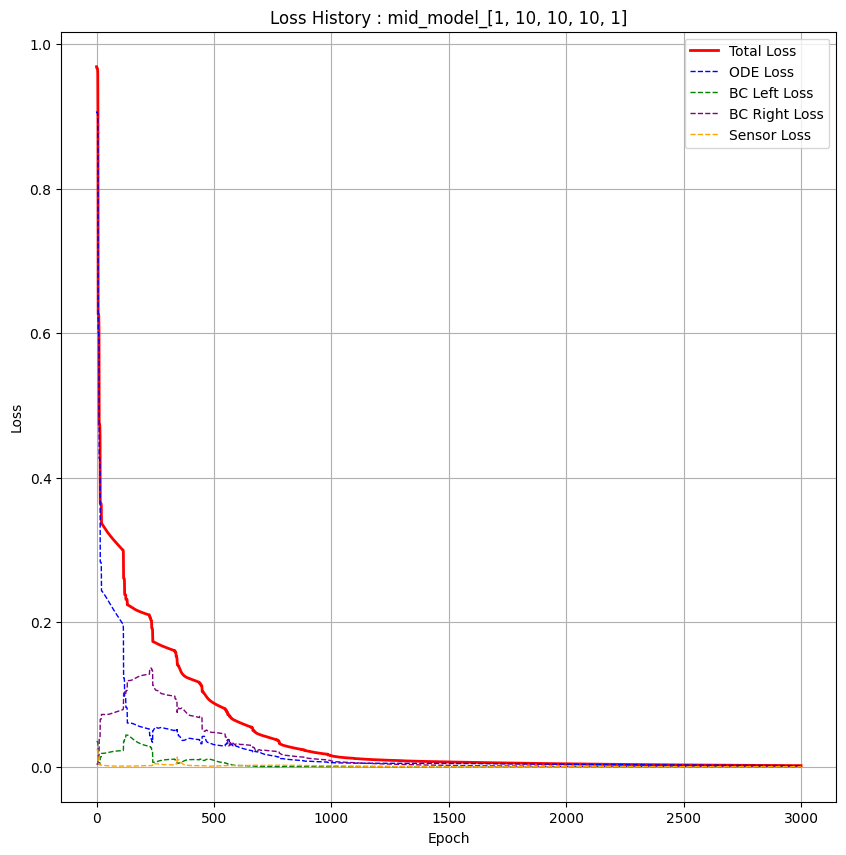

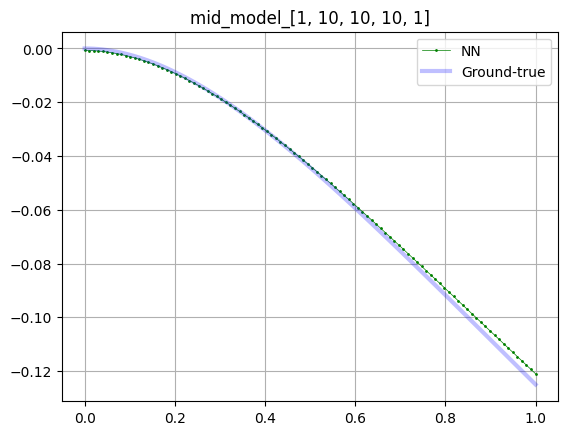

---------------------------------------------------------------------------
Scenario mid_model_[1, 10, 10, 10, 10, 10, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model mid_model_[1, 10, 10, 10, 10, 10, 1] Model size: 471
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
  )
  (1-4): 4 x Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
  )
  (5): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 0.9955968856811523, Loss sensor: 0.004876061342656612, Loss ODE: 0.9906407594680786, Loss BC Left: 7.944363460410386e-05, Loss BC Right: 5.96760060034284

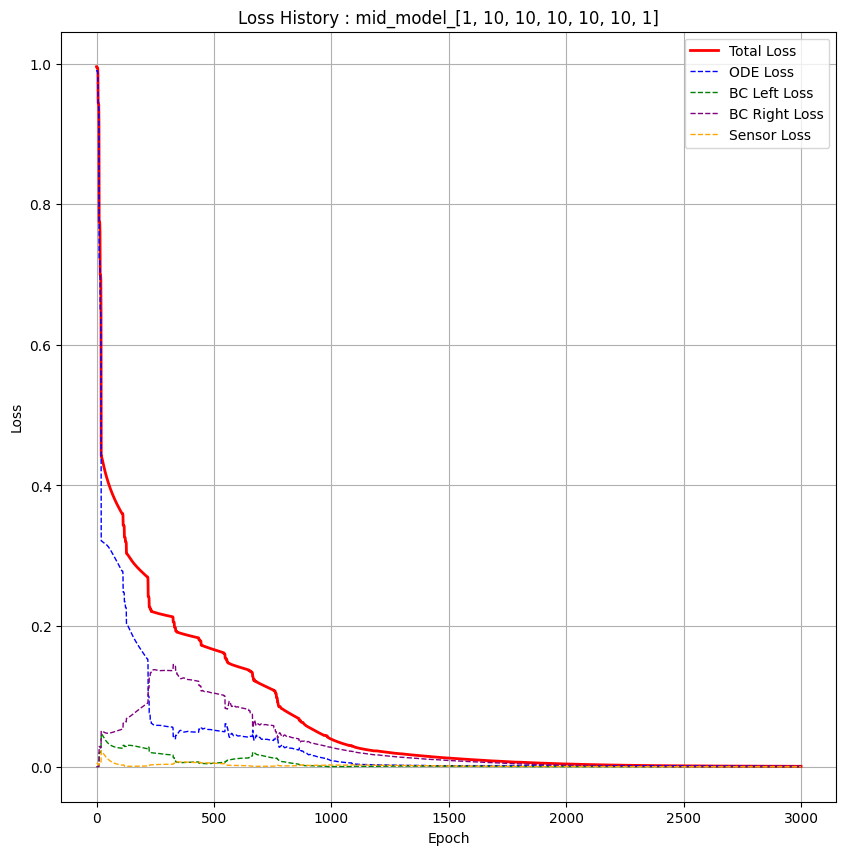

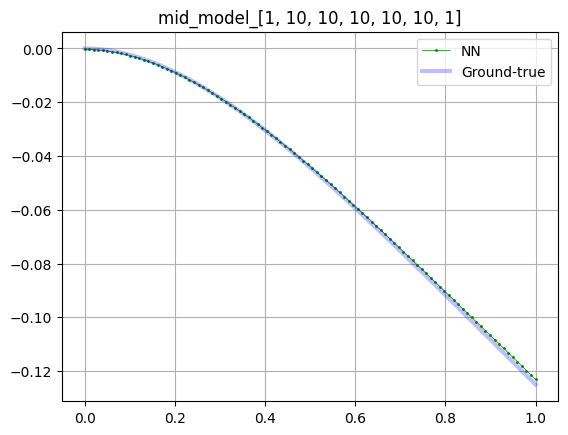

---------------------------------------------------------------------------
Scenario high_model_[1, 15, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model high_model_[1, 15, 1] Model size: 46
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 2.005899429321289, Loss sensor: 0.02519027329981327, Loss ODE: 1.7398042678833008, Loss BC Left: 0.16497990489006042, Loss BC Right: 0.0759248211979866
Epoch: 100, Loss: 0.5944377779960632, Loss sensor: 0.006120005622506142, Loss ODE: 0.5098789930343628, Loss BC Left: 0.0165516696870327, 

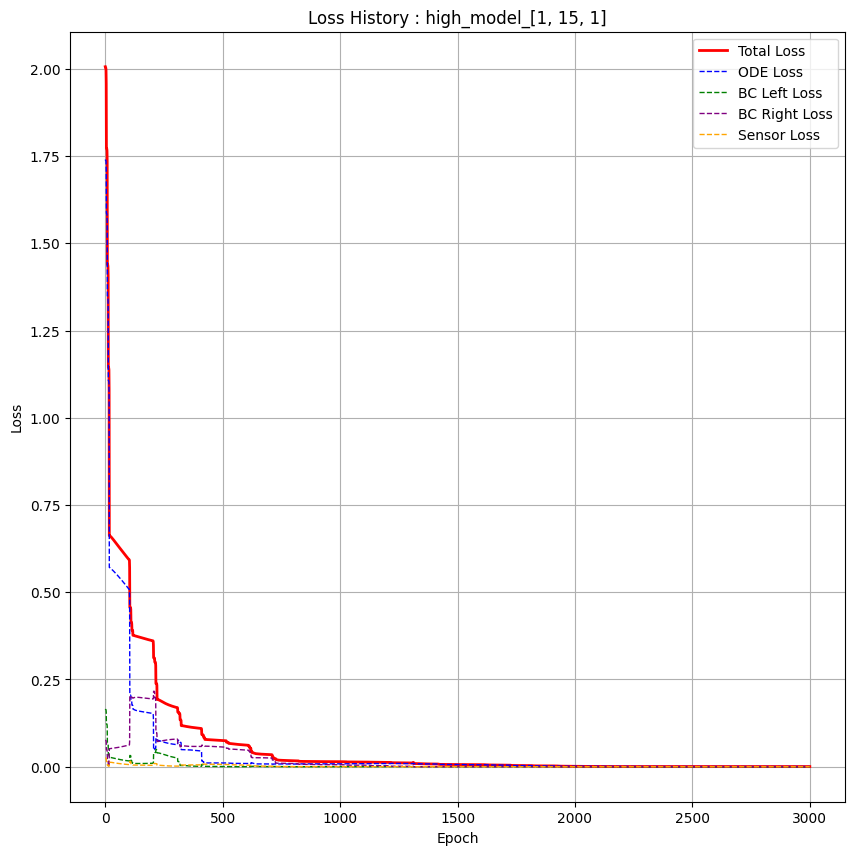

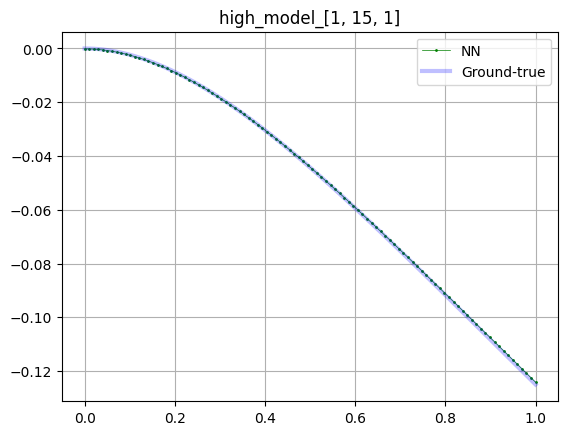

---------------------------------------------------------------------------
Scenario high_model_[1, 15, 15, 15, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model high_model_[1, 15, 15, 15, 1] Model size: 526
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1-2): 2 x Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.2334470748901367, Loss sensor: 0.007263252977281809, Loss ODE: 1.2009981870651245, Loss BC Left: 0.020762424916028976, Loss BC Right: 0.004423098172992468
Epoch: 100

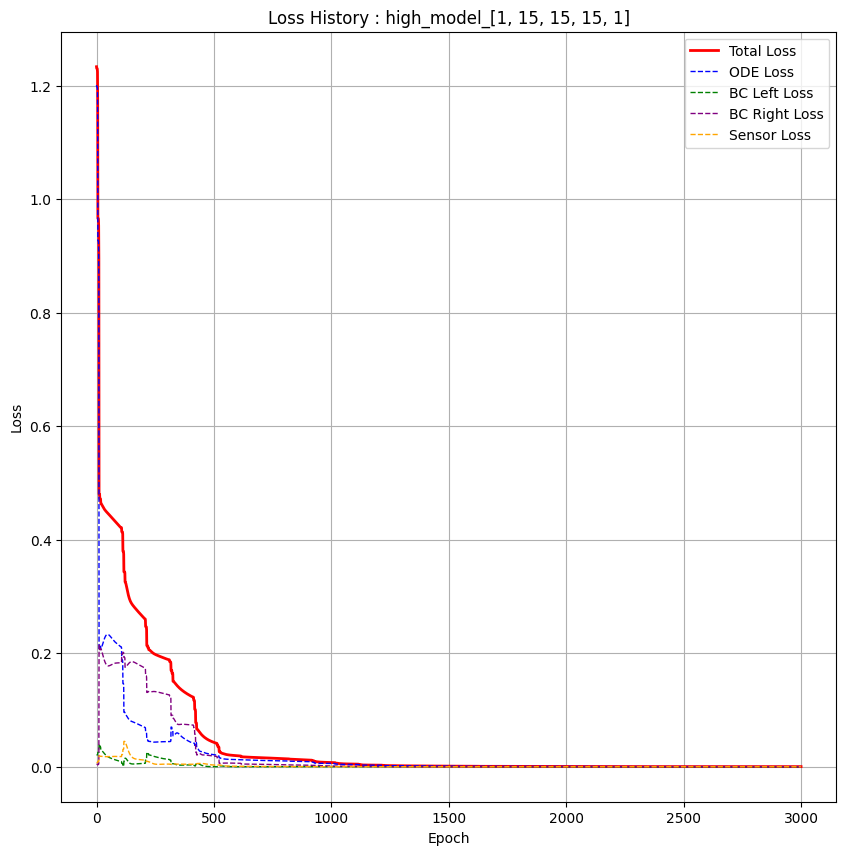

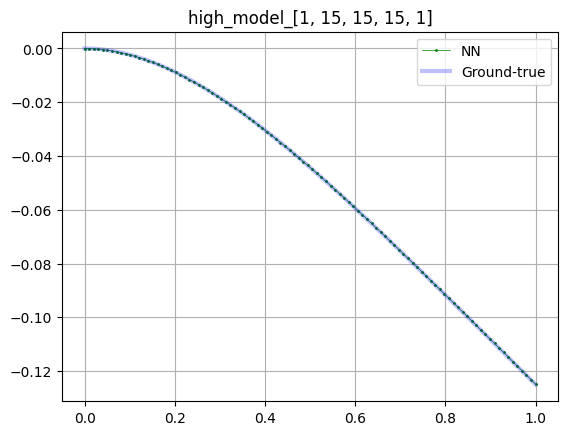

---------------------------------------------------------------------------
Scenario high_model_[1, 15, 15, 15, 15, 15, 1]
---------------------------------------------------------------------------
Options {'L': 1, 'data_size': 50, 'lr': 0.0001, 'epoch': 3000, 'sensor_step': 3}
---------------------------------------------------------------------------
Model high_model_[1, 15, 15, 15, 15, 15, 1] Model size: 1006
Archtecutre: ModuleList(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=15, bias=True)
    (1): Tanh()
  )
  (1-4): 4 x Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Tanh()
  )
  (5): Sequential(
    (0): Linear(in_features=15, out_features=1, bias=True)
    (1): Identity()
  )
)
---------------------------------------------------------------------------
Training
Epoch: 0, Loss: 1.0459294319152832, Loss sensor: 0.005363261792808771, Loss ODE: 1.028699278831482, Loss BC Left: 0.011318325996398926, Loss BC Right: 0.0005486106965

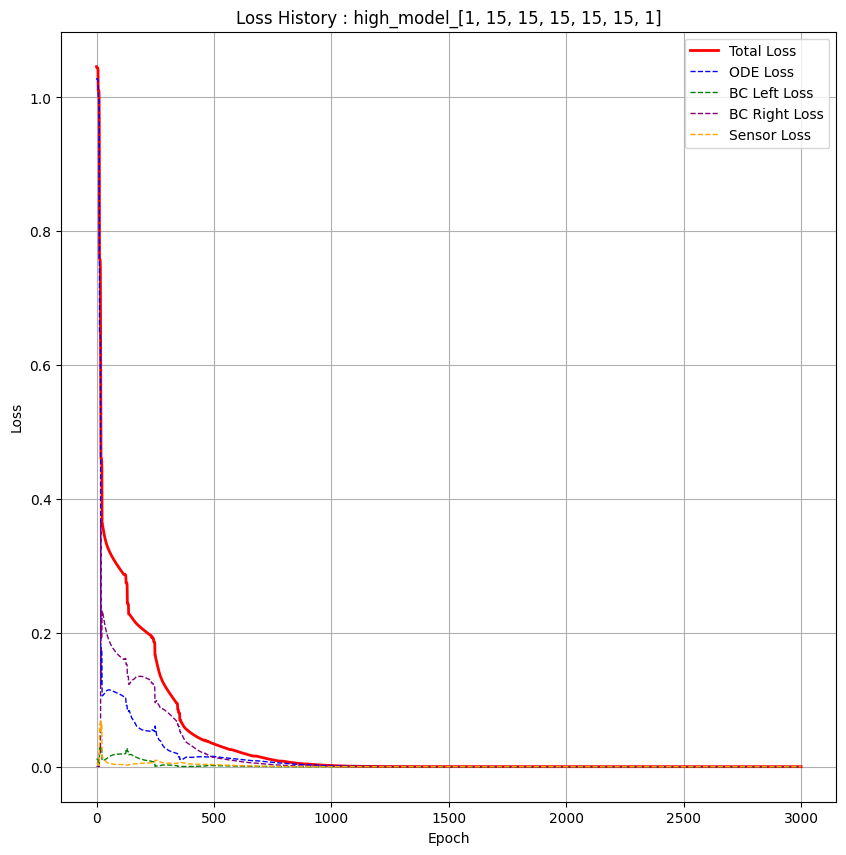

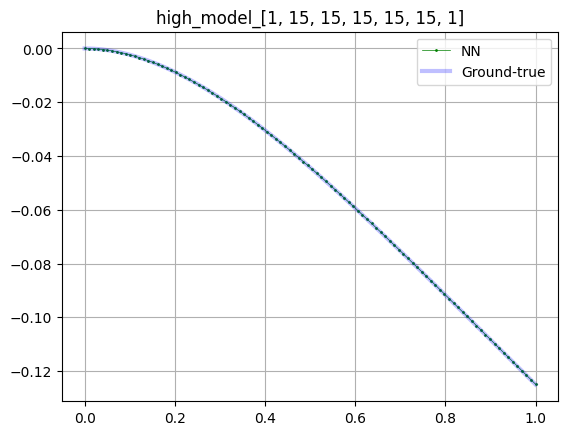

In [9]:
model_architectures_low = [
    [1, 5, 1],
    [1, 5, 5, 5, 1],
    [1, 5, 5, 5, 5, 5, 1],
]

for low in model_architectures_low:
    model = PolymorphicModel(
        activation_functions="tanh",
        model_architecture=low,
    )

    create_scenario(
        scenario_name=f"low_model_{low}",
        opt={
            "L": 1,
            "data_size": 50,
            "lr": 1e-4,
            "epoch": 3000,
            "sensor_step": 3,
        },
        model=model,
    )

model_architectures_mid = [
    [1, 10, 1],
    [1, 10, 10, 10, 1],
    [1, 10, 10, 10, 10, 10, 1],
]

for mid in model_architectures_mid:
    model = PolymorphicModel(
        activation_functions="tanh",
        model_architecture=mid,
    )

    create_scenario(
        scenario_name=f"mid_model_{mid}",
        opt={
            "L": 1,
            "data_size": 50,
            "lr": 1e-4,
            "epoch": 3000,
            "sensor_step": 3,
        },
        model=model,
    )

model_architectures_high = [
    [1, 15, 1],
    [1, 15, 15, 15, 1],
    [1, 15, 15, 15, 15, 15, 1],
]

for high in model_architectures_high:
    model = PolymorphicModel(
        activation_functions="tanh",
        model_architecture=high,
    )

    create_scenario(
        scenario_name=f"high_model_{high}",
        opt={
            "L": 1,
            "data_size": 50,
            "lr": 1e-4,
            "epoch": 3000,
            "sensor_step": 3,
        },
        model=model,
    )